In [654]:
import re
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import requests
import feather
from pytrends.request import TrendReq
import pytrends
import pickle
from multiprocessing import Pool
import random
import patsy

In [402]:
PATH = '/Users/sethweiland/Documents/metis_projects/metis_project_2/soccer_transfers/transfers/transfer_data/'


In [403]:
years = ["2015/","2016/","2017/","2018/"]

In [406]:
data_files = !ls "./transfer_data/2018"

In [407]:
data_files



['dutch_eredivisie.csv',
 'english_championship.csv',
 'english_premier_league.csv',
 'french_ligue_1.csv',
 'german_bundesliga_1.csv',
 'italian_serie_a.csv',
 'portugese_liga_nos.csv',
 'russian_premier_liga.csv',
 'spanish_primera_division.csv']

In [408]:
list_dfs = []
for year in years:
    for file in data_files:
        df = pd.read_csv(PATH+year+file)
        list_dfs.append(df)
df_15_16_17_18 = pd.concat(list_dfs)

In [409]:
#Removing Values Where transfer fee is below one million
#this is because most transfers for the large european leagues
#are above this and the performance data for the smaller leagues 
#could be hard to obtain
df_15_16_17_18 = df_15_16_17_18.loc[df_15_16_17_18['fee_cleaned']>1]


In [410]:
df_15_16_17_18.head()

,club_name,player_name,age,position,club_involved_name,fee,transfer_movement,fee_cleaned,league_name,year,season
0,PSV Eindhoven,Gastón Pereiro,20.0,Attacking Midfield,Nacional,£6.30m,in,6.30,Eredivisie,2015,2015/2016
1,PSV Eindhoven,Davy Pröpper,23.0,Central Midfield,Vitesse,£4.05m,in,4.05,Eredivisie,2015,2015/2016
2,PSV Eindhoven,Héctor Moreno,27.0,Centre-Back,Espanyol,£3.15m,in,3.15,Eredivisie,2015,2015/2016
3,PSV Eindhoven,Andrés Guardado,28.0,Central Midfield,Valencia,£2.52m,in,2.52,Eredivisie,2015,2015/2016
4,PSV Eindhoven,Nicolas Isimat-Mirin,23.0,Centre-Back,Monaco,£2.16m,in,2.16,Eredivisie,2015,2015/2016


In [411]:
#there are duplicates for almost every player acquisition
#each transfer has an "in" and an "out" row so i am removing these
df_15_16_17_18_in = (df_15_16_17_18
                     .loc[df_15_16_17_18['transfer_movement']=="in"]
                    )

In [9]:
df_15_16_17_18.shape

(4259, 11)

In [10]:
df_15_16_17_18_in.shape

(2395, 11)

In [12]:
#just want to see if there are still duplicates, although must keep in mind
#some players will have changed teams more than once in this time period

names = df_15_16_17_18_in['player_name'].unique()

In [13]:
len(names)

1935

## Scrape Goals and Appearances

In [14]:
#creating a column that mimics wikipedia table data format for scraping
df_15_16_17_18_in['wiki_format_season'] = (df_15_16_17_18_in['season'].str.slice(0,4) + "-"
                                           +df_15_16_17_18_in['season'].str.slice(-2,))

In [15]:
#wikipedia endpoints end in "{first_name}_{last_name}" 
#so creating column to help automate scraping
df_15_16_17_18_in["name_under"] = df_15_16_17_18_in['player_name'].str.split().str.join("_")
df_15_16_17_18_in['name_under'].head()

0          Gastón_Pereiro
1            Davy_Pröpper
2           Héctor_Moreno
3         Andrés_Guardado
4    Nicolas_Isimat-Mirin
Name: name_under, dtype: object

In [16]:
#creating a unique to each row primary key in order
#to help with making sure get goals for a player for the season needed
df_15_16_17_18_in['player_season'] = list(zip(df_15_16_17_18_in['player_name'].str.split().str.join("_"), df_15_16_17_18_in['wiki_format_season']))


In [17]:
array_player_season = np.array(df_15_16_17_18_in['player_season'].unique())

In [18]:
array_player_season

array([('Gastón_Pereiro', '2015-16'), ('Davy_Pröpper', '2015-16'),
       ('Héctor_Moreno', '2015-16'), ..., ('José_Pozo', '2018-19'),
       ('Sergi_Guardiola', '2018-19'), ('Stiven_Plaza', '2018-19')],
      dtype=object)

In [19]:
wikipedia_base_endpoint = "https://en.wikipedia.org/wiki/"

In [20]:
array_player_season

array([('Gastón_Pereiro', '2015-16'), ('Davy_Pröpper', '2015-16'),
       ('Héctor_Moreno', '2015-16'), ..., ('José_Pozo', '2018-19'),
       ('Sergi_Guardiola', '2018-19'), ('Stiven_Plaza', '2018-19')],
      dtype=object)

In [24]:

def get_soup(base_endpoint,player_name):
    http_endpoint = base_endpoint+player_name
    req = requests.get(http_endpoint)
    soup = BeautifulSoup(req.text)
    return soup

In [22]:
#this function scrapes beautiful soup object for # appearances
#and goals for season needed
def get_app_goals_recent(soup,season):
    list_season = season.split("-")
    int_season_first = int(list_season[0][2:])-1
    str_season = "20" + str(int_season_first) + "–" + list_season[0][2:]
    re_season = re.compile(str_season)
    stats_box = soup.find(class_="wikitable") 
    stats_body = stats_box.tbody
    for tr in stats_body.find_all("tr"): 
        string_tr = tr.text
        list_tr = list(string_tr.split())
        for item in list_tr:
            match = re.search(re_season,str(item))
            if match:
                goals_season=list_tr[-1]
                appearances_season = list_tr[-2]
                return (appearances_season, goals_season)

In [23]:
list_tuple_w_apps_goals = []
bad_endpoint = []
for player_season in array_player_season:
    try:
        soup = get_soup("https://en.wikipedia.org/wiki/",player_season[0])
        goals_app_season = get_app_goals_recent(soup,player_season[1])
        tuple_w_apps_goals = player_season + (goals_app_season)
        print(tuple_w_apps_goals)
        list_tuple_w_apps_goals.append(tuple_w_apps_goals)
    except:
        bad_endpoint.append(player_season)
    

('Gastón_Pereiro', '2015-16', '25', '7')
('Davy_Pröpper', '2015-16', '38', '7')
('Héctor_Moreno', '2015-16', '29', '1')
('Andrés_Guardado', '2015-16', '1', '0')
('Nemanja_Gudelj', '2015-16', '36', '12')
('Arkadiusz_Milik', '2015-16', '33', '23')
('Amin_Younes', '2015-16', '15', '2')
('Alireza_Jahanbakhsh', '2015-16', '31', '13')
('Eric_Botteghin', '2015-16', '41', '3')
('Renato_Tapia', '2015-16', '2', '0')
('Jesper_Drost', '2015-16', '44', '10')
('Moses_Odubajo', '2015-16', '49', '3')
('Shaun_Maloney', '2015-16', '22', '2')
('Sam_Clucas', '2015-16', '6', '0')
('Andre_Gray', '2015-16', '50', '18')
('James_Tarkowski', '2015-16', '38', '1')
('Rouwen_Hennings', '2015-16', '18', '[21]')
('Matthew_Lowton', '2015-16', '13', '0')
('Massimo_Luongo', '2015-16', '42', '6')
('Conor_Washington', '2015-16', '44', '13')
('Tjaronn_Chery', '2015-16', '42', '17')
('Sebastian_Polter', '2015-16', '14', '[7]')
('Alex_Smithies', '2015-16', '45', '0')
('James_Perch', '2015-16', '42', '3')
('Jordan_Rhodes', '

('Max_Kruse', '2015-16', '42', '13')
('Jonas_Hofmann', '2015-16', '3', '0')
('Thorgan_Hazard', '2015-16', '41', '5')
('Nico_Elvedi', '2015-16', '24', '1')
('Nico_Schulz', '2015-16', '29', '1')
('Lars_Stindl', '2015-16', '11', '[23]')
('Chicharito', '2015-16', '2', '0')
('Kevin_Kampl', '2015-16', '11', '[16]')
('Admir_Mehmedi', '2015-16', '32', '7')
('Jonathan_Tah', '2015-16', '23', '0')
('Jeffrey_Gouweleeuw', '2015-16', '38', '2')
('Konstantinos_Stafylidis', '2015-16', '44', '0')
('Dominik_Kohr', '2015-16', '1', '[24]')
('Johannes_Geis', '2015-16', '37', '5')
('Matija_Nastasic', '2015-16', '1', '0')
('Franco_Di_Santo', '2015-16', '28', '14')
('Alessandro_Schöpf', '2015-16', '5', '[8]')
('Júnior_Caiçara', '2015-16', '44', '0')
('Gonzalo_Castro', '2015-16', '2', '[22]')
('Roman_Bürki', '2015-16', '36', '0')
('Julian_Weigl', '2015-16', '0', '[17]')
('Eduardo_Vargas', '2015-16', '22', '4')
('Fabian_Schär', '2015-16', '41', '1')
('Jonathan_Schmid', '2015-16', '37', '5')
('Mark_Uth', '2015-1

('Birkir_Bjarnason', '2016-17', '40', '12')
('Shane_Duffy', '2016-17', '42', '4')
('Glenn_Murray', '2016-17', '3', '1')
('Matej_Vydra', '2016-17', '1', '0')
('Ikechi_Anya', '2016-17', '33', '0')
('David_Nugent', '2016-17', '40', '8')
('Adam_Reach', '2016-17', '6', '1')
('Almen_Abdi', '2016-17', '38', '1')
('Lex_Immers', '2016-17', '6', '0')
('Rickie_Lambert', '2016-17', '24', '1')
('Rico_Henry', '2016-17', '44', '3')
('Kerim_Frei', '2016-17', '37', '5')
('Che_Adams', '2016-17', '41', '12')
('Cheick_Keita', '2016-17', '32', '0')
('Emilio_Nsue', '2016-17', '46', '3')
('Lukas_Jutkiewicz', '2016-17', '6', '0')
('Idrissa_Sylla', '2016-17', '35', '7')
('Pawel_Wszolek', '2016-17', '4', '0')
('Ariel_Borysiuk', '2016-17', '22', '2')
('Jake_Bidwell', '2016-17', '47', '3')
('Jordan_Cousins', '2016-17', '42', '2')
('Joel_Lynch', '2016-17', '40', '2')
('Kemar_Roofe', '2016-17', '48', '26')
('Liam_Bridcutt', '2016-17', '0', '0')
('Ivan_Cavaleiro', '2016-17', '19', '3')
('Romain_Saïss', '2016-17', '3

('Riechedly_Bazoer', '2016-17', '39', '5')
('Jeffrey_Bruma', '2016-17', '44', '0')
('Josip_Brekalo', '2016-17', '9', '0')
('Jakub_Blaszczykowski', '2016-17', '20', '2')
('Josuha_Guilavogui', '2016-17', '42', '2')
('Borja_Mayoral', '2016-17', '33', '15')
('Philipp_Wollscheid', '2016-17', '39', '0')
('Marco_Höger', '2016-17', '0', '[9]')
('Filip_Kostic', '2016-17', '33', '5')
('Alen_Halilovic', '2016-17', '37', '5')
('Mërgim_Mavraj', '2016-17', '4', '0')
('Florent_Hadergjonaj', '2016-17', '37', '0')
('Martin_Hinteregger', '2016-17', '13', '1')
('Jonathan_Schmid', '2016-17', '24', '4')
('Alfred_Finnbogason', '2016-17', '13', '2')
('Moritz_Leitner', '2016-17', '3', '[71]')
('Max_Kruse', '2016-17', '43', '9')
('Serge_Gnabry', '2016-17', '0', '[28]')
('Florian_Kainz', '2016-17', '47', '11')
('Niklas_Moisander', '2016-17', '23', '0')
('Fallou_Diagne', '2016-17', '24', '6')
('Roman_Bezjak', '2016-17', '39', '17')
('Andrej_Kramaric', '2016-17', '5', '1')
('Sandro_Wagner', '2016-17', '15', '[17]

('Cyrus_Christie', '2017-18', '30', '1')
('Sone_Aluko', '2017-18', '51', '9')
('Vito_Mannone', '2017-18', '11', '0')
('Modou_Barrow', '2017-18', '19', '0')
('Leandro_Bacuna', '2017-18', '31', '1')
('Jordan_Rhodes', '2017-18', '6', '0')
('Joost_van_Aken', '2017-18', '28', '1')
('Rui_Fonte', '2017-18', '33', '13')
('Aboubakar_Kamara', '2017-18', '29', '10')
('Ibrahima_Cissé', '2017-18', '27', '1')
('Adam_Forshaw', '2017-18', '35', '0')
('Pontus_Jansson', '2017-18', '36', '3')
('Samu_Sáiz', '2017-18', '44', '12')
('Tyler_Roberts', '2017-18', '22', '2')
('Ezgjan_Alioski', '2017-18', '35', '16')
('Laurens_De_Bock', '2017-18', '24', '0')
('Hadi_Sacko', '2017-18', '42', '2')
('Jay-Roy_Grot', '2017-18', '24', '6')
('Grant_Hanley', '2017-18', '16', '1')
('Marcel_Franke', '2017-18', '34', '2')
('Onel_Hernández', '2017-18', '36', '5')
('Marco_Stiepermann', '2017-18', '32', '1')
('Dennis_Srbeny', '2017-18', '33', '18')
('Tom_Lawrence', '2017-18', '36', '11')
('Andre_Wisdom', '2017-18', '24', '0')


('Michy_Batshuayi', '2017-18', '28', '9')
('Nico_Schulz', '2017-18', '16', '1')
('Justin_Hoogma', '2017-18', '38', '0')
('Jorge_Meré', '2017-18', '32', '0')
('Simon_Terodde', '2017-18', '33', '25')
('Vincent_Koziello', '2017-18', '34', '1')
('Davie_Selke', '2017-18', '21', '4')
('Mathew_Leckie', '2017-18', '32', '0')
('Karim_Rekik', '2017-18', '12', '1')
('Yoric_Ravet', '2017-18', '43', '9')
('Pascal_Stenzel', '2017-18', '19', '1')
('Marco_Terrazzino', '2017-18', '3', '3')
('Milot_Rashica', '2017-18', '39', '4')
('Ludwig_Augustinsson', '2017-18', '50', '2')
('Jiri_Pavlenka', '2017-18', '0', '[7]')
('Matthias_Ginter', '2017-18', '41', '0')
('Vincenzo_Grifo', '2017-18', '32', '9')
('Nabil_Bentaleb', '2017-18', '44', '7')
('Yevhen_Konoplianka', '2017-18', '2', '1')
('Amine_Harit', '2017-18', '34', '1')
('Bastian_Oczipka', '2017-18', '38', '1')
('Pablo_Insua', '2017-18', '30', '1')
('Sébastien_Haller', '2017-18', '39', '16')
('Jetro_Willems', '2017-18', '2', '[6]')
('Simon_Falette', '2017-

('Javi_García', '2017-18', '31', '1')
('Fabian_Schär', '2017-18', '7', '0')
('Dimitrios_Siovas', '2017-18', '2', '0')
('Ezequiel_Muñoz', '2017-18', '32', '0')
('Enis_Bardhi', '2017-18', '31', '13')
('Bernardo_Espinosa', '2017-18', '15', '0')
('Cristhian_Stuani', '2017-18', '28', '5')
('Daley_Blind', '2018-19', '17', '1')
('Dusan_Tadic', '2018-19', '41', '7')
('Zakaria_Labyad', '2018-19', '39', '18')
('Ritsu_Doan', '2018-19', '31', '10')
('Érick_Gutiérrez', '2018-19', '33', '6')
('Aziz_Behich', '2018-19', '34', '5')
('Matus_Bero', '2018-19', '19', '1')
('Bersant_Celina', '2018-19', '38', '8')
('Joel_Asoro', '2018-19', '29', '3')
('Benik_Afobe', '2018-19', '22', '1')
('Tom_Ince', '2018-19', '37', '3')
('Sam_Vokes', '2018-19', '32', '4')
('Oghenekaro_Etebo', '2018-19', '19', '4')
('Sam_Clucas', '2018-19', '3', '0')
('James_McClean', '2018-19', '34', '1')
('Danny_Batth', '2018-19', '21', '2')
('Sam_Johnstone', '2018-19', '0', '0')
('Kyle_Bartley', '2018-19', '10', '0')
('Lovre_Kalinic', '2

('Martin_Harnik', '2018-19', '11', '[14]')
('André_Hahn', '2018-19', '3', '[12]')
('Walace', '2018-19', '19', '1')
('Genki_Haraguchi', '2018-19', '0', '1')
('Josip_Elez', '2018-19', '26', '2')
('Kevin_Wimmer', '2018-19', '19', '0')
('Florent_Muslija', '2018-19', '44', '1')
('Jean-Philippe_Mateta', '2018-19', '38', '20')
('Jean-Paul_Boëtius', '2018-19', '37', '6')
('Roland_Sallai', '2018-19', '1', '0')
('Philipp_Lienhart', '2018-19', '14', '0')
('Daniel_Ginczek', '2018-19', '25', '8')
('Wout_Weghorst', '2018-19', '37', '27')
('Jérôme_Roussillon', '2018-19', '25', '3')
('Felix_Klaus', '2018-19', '29', '4')
('Marvin_Ducksch', '2018-19', '37', '19')
('Benito_Raman', '2018-19', '1', '0')
('Virgil_Misidjan', '2018-19', '39', '13')
('Duván_Zapata', '2018-19', '32', '11')
('Bryan_Cristante', '2018-19', '47', '12')
('Marco_Tumminello', '2018-19', '1', '0')
('Marco_Carraro', '2018-19', '24', '0')
('Pierluigi_Gollini', '2018-19', '8', '0')
('Diego_Falcinelli', '2018-19', '23', '3')
('Lukasz_Skoru

## Scrape Heights

In [36]:
def get_height(soup):
    height = re.compile("\d\.\d{2}")
    height_box = soup.find(class_="infobox vcard")
    table_body = height_box.tbody
    for tr in table_body.find_all("tr"): 
        string_tr_text = str(tr.text)
        match = re.search(height,string_tr_text)
        if match:
            print(match.group(0))
            return match.group(0)
        else:
            return np.nan
            
        

In [25]:
endpoint_names = df_15_16_17_18_in['name_under'].values

In [26]:
dict_heights = defaultdict(float)

In [31]:
endpoint_names

array(['Gastón_Pereiro', 'Davy_Pröpper', 'Héctor_Moreno', ...,
       'José_Pozo', 'Sergi_Guardiola', 'Stiven_Plaza'], dtype=object)

In [37]:
invalid_endpoints = []
list_tuple_w_heights = []


for name in endpoint_names:
    try:
        soup = get_soup("https://en.wikipedia.org/wiki/",name)
        height_get = get_height(soup)
        tuple_w_name_height = (name,height_get)
        print(tuple_w_name_height)
        dict_heights[name] = height_get
        list_tuple_w_heights.append(tuple_w_name_height)
        
    except:
        invalid_endpoints.append(name) 

Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.88
('Gastón_Pereiro', '1.88')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.85
('Davy_Pröpper', '1.85')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.82
('Héctor_Moreno', '1.82')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.69
('Andrés_Guardado', '1.69')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.89
('Nicolas_Isimat-Mirin', '1.89')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.88
('Nemanja_Gudelj', '1.88')
Error culd not get heigh

Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.88
('Nick_Blackman', '1.88')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.77
('Abdoul_Camara', '1.77')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.82
('Diego_Fabbrini', '1.82')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
('Naby_Sarr', None)
Er

Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.88
('Charlie_Austin', '1.88')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.91
('Steven_Caulker', '1.91')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.85
('Cuco_Martina', '1.85')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.83
('Alberto_Paloschi', '1.83')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.78
('Franck_Tabanou', '1.78')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.86
('Giannelli_Imbula', '1.86')
Error culd not get height
Error culd not get height


Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.78
('Adam_Matthews', '1.78')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.96
('Sebastián_Coates', '1.96')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.86
("Dame_N'Doye", '1.86')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.82
('Jordan_Ayew', '1.82')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.76
('Jordan_Amavi', '1.76')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.77
('Jordan_Veretout', '1.77')
Error culd not get height
Error culd not get height
Error cu

Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.72
('Thomas_Lemar', '1.72')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.70
('Corentin_Jean', '1.70')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.81
('Farès_Bahlouli', '1.81')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.78
('Stephan_El_Shaarawy', '1.78')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.72
('Vágner_Love', '1.72')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.87
('Lucas_Ocampos', '1.87')
Error culd not get height
Error culd not get height
Erro

Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.78
('Kevin_Kampl', '1.78')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.83
('Admir_Mehmedi', '1.83')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.95
('Jonathan_Tah', '1.95')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.83
('Kyriakos_Papadopoulos', '1.83')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.78
('Philipp_Max', '1.78')
Error culd not get height
Error culd not get height
Error culd not get height
1.87
('Jeffrey_Gouweleeuw', '1.87')
Error culd not get height
Error culd not get height
Error culd not get height


Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.84
('Josip_Drmic', '1.84')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.78
('Darío_Lezcano', '1.78')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.76
('Elias_Kachunga', '1.76')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.77
('Paulo_Dybala', '1.77')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.77
('Alex_Sandro', '1.77')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.90
('Mario_Mandzukic', '1.90')
Error culd not get height
Error culd

Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.82
('Jeison_Murillo', '1.82')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.83
('Felipe_Melo', '1.83')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.87
('Davide_Santon', '1.87')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.83
('Stevan_Jovetic', '1.83')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.82
('Adem_Ljajic', '1.82')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.74
('Martín_Montoya', '1.74')
Error culd not get height
Error cul

Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.71
('Alejandro_Grimaldo', '1.71')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.86
('Giannelli_Imbula', '1.86')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.83
('Moussa_Marega', '1.83')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.74
('André_André', '1.74')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.78
('Teófilo_Gutiérrez', '1.78')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.88
('Ewerton', '1.88')
Error culd not get height
Erro

Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.78
('Nordin_Amrabat', '1.78')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.79
('Federico_Ricca', '1.79')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.79
('Adnane_Tighadouini', '1.79')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not g

Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.81
('Conor_Hourihane', '1.81')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.85
('Albert_Adomah', '1.85')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.83
('Henri_Lansbury', '1.83')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.86
('Ritchie_De_Laet', '1.86')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.83
('Birkir_Bjarnason', '1.83')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.93
('Shane_Duffy', '1.93')
Error culd not get height
Error culd not get height
Er

Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.74
('Floyd_Ayité', '1.74')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.81
('Michael_Madl', '1.81')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.88
('Islam_Slimani', '1.88')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.73
('Ahmed_Musa', '1.73')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.83
('Wilfred_Ndidi', '1.83')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.67
('Nampalys_Mendy', '1.67')
Error culd not get height
Error culd not get height
Error culd no

Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.89
('David_Luiz', '1.89')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.85
('Yannick_Bolasie', '1.85')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.85
('Morgan_Schneiderlin', '1.85')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.74
('Ademola_Lookman', '1.74')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.74
('Idrissa_Gueye', '1.74')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.87
('Dominic_Calvert-Lewin', '1.87')
Error culd not get 

Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.80
('Kamil_Grosicki', '1.80')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.87
('Markus_Henriksen', '1.87')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.95
('Andrea_Ranocchia', '1.95')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.88
('Will_Keane', '1.88')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.85
('Julian_Draxler', '1.85')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.79
('Gonçalo_Guedes', '1.79')
Error culd not get height
Error culd not get height
Er

Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.78
('Vincent_Marchetti', '1.78')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.76
('Renato_Sanches', '1.76')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.92
('Mats_Hummels', '1.92')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.84
('André_Schürrle', '1.84')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.76
('Mario_Götze', '1.76')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.78
('Ousmane_Dembélé', '1.78')
Error culd not get height
Error culd not get height
Err

Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.82
('Florent_Hadergjonaj', '1.82')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.83
('Robert_Leipertz', '1.83')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.86
('Martin_Hinteregger', '1.86')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.79
('Jonathan_Schmid', '1.79')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.85
('Alfred_Finnbogason', '1.85')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.76
('Moritz_Leitner', '1.76')
Error culd not get height
Error culd not get height
Error culd no

Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.78
('Diego_Laxalt', '1.78')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.80
('Giovanni_Simeone', '1.80')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.81
('Cristian_Ansaldi', '1.81')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.85
('Davide_Brivio', '1.85')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.80
('Leonardo_Morosini', '1.80')
Error culd not get height
Error culd not get height
Error culd not get height
1.82
('Davide_Biraschi', '1.82')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.82
('Nikola_Ninkovic', '1.82')
Error culd not g

Error culd not get height
Error culd not get height
Error culd not get height
1.82
('Abdullahi_Nura', '1.82')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.92
('Umar_Sadiq', '1.92')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.85
('Juan_Jesus', '1.85')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.89
('Norbert_Gyömbér', '1.89')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.95
('Federico_Fazio', '1.95')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.81
('Dennis_Praet', '1.81')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd 

Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.76
('Maxime_Lestienne', '1.76')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.79
('Rubén_Rochina', '1.79')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.81
('Moritz_Bauer', '1.81')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.90
('Aleksandr_Selikhov', '1.90')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.78
('Aleksandr_Samedov', '1.78')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.85
('Roman_Zobnin', '1.85')
Error culd not get heigh

Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.73
('Pione_Sisto', '1.73')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.77
('Andrew_Hjulsager', '1.77')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.80
('Florin_Andone', '1.80')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.89
('Gerónimo_Rulli', '1.89')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.89
('Willian_José', '1.89')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.88
('Ezequiel_Garay', '1.88')
Error culd not get height
Error culd not get height
Error 

Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.80
('Tyler_Roberts', '1.80')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
('Ezgjan_Alioski', None)
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.79
('Laurens_De_Bock', '1.79')
Error culd not get height
Error culd not get height
Error culd not get height
E

Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.91
('Aymeric_Laporte', '1.91')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.83
('Benjamin_Mendy', '1.83')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.78
('Kyle_Walker', '1.78')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.73
('Bernardo_Silva', '1.73')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.76
('Douglas_Luiz', '1.76')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.74
('Olarenwaju_Kayode', '1.74')
Error culd not get height
Err

Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.90
('Kurt_Zouma', '1.90')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.85
('Bruno_Martins_Indi', '1.85')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.81
('Moritz_Bauer', '1.81')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.87
('Mamadou_Sakho', '1.87')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.82
('Jairo_Riedewald', '1.82')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.92
('Jaroslaw_Jach', '1.92')
Error culd not get height
Error culd not get height
Error

Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.83
('Angelo_Fulgini', '1.83')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.77
('Nicolas_de_Préville', '1.77')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.73
('Jonathan_Cafú', '1.73')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.74
('Youssouf_Sabaly', '1.74')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.86
('Lukas_Lerager', '1.86')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.88
('Vukasin_Jovanovic', '1.88')
Error culd not get he

Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.78
('Kylian_Mbappé', '1.78')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.81
('Yuri_Berchiche', '1.81')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.85
('Ismaïla_Sarr', '1.85')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.84
('Diafra_Sakho', '1.84')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.70
('Rafik_Guitane', '1.70')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.70
('Faitout_Maouassa', '1.70')
Error culd not get height
Error culd not get height
Error culd not get height
Error 

Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.96
('Jiri_Pavlenka', '1.96')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.75
('Jérôme_Gondorf', '1.75')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.89
('Matthias_Ginter', '1.89')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.89
('Denis_Zakaria', '1.89')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.80
('Vincenzo_Grifo', '1.80')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.81
('Raúl_Bobadilla', '1.81')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Err

Error culd not get height
Error culd not get height
Error culd not get height
1.84
('Federico_Mattiello', '1.84')
Error culd not get height
Error culd not get height
Error culd not get height
1.87
('José_Luis_Palomino', '1.87')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.95
('Andreas_Cornelius', '1.95')
Error culd not get height
Error culd not get height
Error culd not get height
1.87
('Matteo_Pessina', '1.87')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.88
('Andrew_Gravillon', '1.88')
Error culd not get height
Error culd not get height
Error culd not get height
1.85
('Gianluca_Di_Chiara', '1.85')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.92
('Jean-Claude_Billong', '1.92')
Error culd not get height
Error culd not get height
Error culd not get height


Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.88
('Benedikt_Höwedes', '1.88')
Error culd not get height
Error culd not get height
Error culd not get height
1.82
('Leonardo_Mancuso', '1.82')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.75
('Matheus_Pereira', '1.75')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.72
('Pedro_Neto', '1.72')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.79
('Lucas_Leiva', '1.79')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.85
('Adam_Marusic', '1.85')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.80
(

Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.91
('Giuseppe_Pezzella', '1.91')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.91
('Bram_Nuytinck', '1.91')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.83
('Mamadou_Coulibaly', '1.83')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.82
('Jens_Stryger_Larsen', '1.82')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.77
('Filip_Krovinovic', '1.77')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.89
('Mile_Svilar', '1.89')
Error culd not get height
Error culd not get height
Error culd not get 

Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.75
('Nolito', '1.75')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.75
('Éver_Banega', '1.75')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.75
('Sébastien_Corchia', '1.75')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.81
('Johannes_Geis', '1.81')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.89
('Rúben_Semedo', '1.89')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.85
('Enes_Ünal', '1.85')
Error culd not get height
Error culd not get

Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.81
('Dusan_Tadic', '1.81')
Error culd not get height
Error culd not get height
Error culd not get height
1.85
('Lisandro_Magallán', '1.85')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.78
('Hassane_Bandé', '1.78')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.75
('Zakaria_Labyad', '1.75')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.72
('Luis_Sinisterra', '1.72')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.72
('Ritsu_Doan', '1.72')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.95
('Julian_Chabot', '1.95')
E

Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.83
('Lewis_Grabban', '1.83')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.83
('El_Arbi_Hillel_Soudani', '1.83')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.88
('Tobias_Figueiredo', '1.88')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.89
('Reece_Burke', '1.89')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.89
('Kristian_Pedersen', '1.89')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.70
('Sam_Baldock', '1.70')
Error culd not get height
Error culd not get height
Error culd not get he

Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.80
('Lucas_Pérez', '1.80')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.88
('Fabián_Balbuena', '1.88')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.77
('Xande_Silva', '1.77')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.77
('Gerard_Deulofeu', '1.77')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.91
('Adam_Masina', '1.91')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.80
('Ken_Sema', '1.80')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not 

Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.86
('Yacine_Adli', '1.86')
Error culd not get height
Error culd not get height
Error culd not get height
1.90
('Toma_Basic', '1.90')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.80
('Josh_Maja', '1.80')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.84
('Enzo_Crivelli', '1.84')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.88
('Yacine_Bammou', '1.88')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.84
('Casimir_Ninga', '1.84')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not ge

Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.80
('Franck_Honorat', '1.80')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.88
('Matz_Sels', '1.88')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.81
('Lebo_Mothiba', '1.81')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.95
('Stefan_Mitrovic', '1.95')
Error culd not get height
Error culd not get height
Error culd not get height
1.93
('Ibrahima_Sissoko', '1.93')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.97
('Ludovic_Ajorque', '1.97')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.78
('Firmin_Mubele', '1.78')
Error culd not get height


Error culd not get height
Error culd not get height
Error culd not get height
1.84
('Lukas_Klünter', '1.84')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.79
('Davy_Klaassen', '1.79')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.82
('Yuya_Osako', '1.82')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.85
('Felix_Beijmo', '1.85')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.85
('Martin_Harnik', '1.85')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.85
('André_Hahn', '1.85')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not 

Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.90
('Germán_Pezzella', '1.90')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.85
('Riccardo_Saponara', '1.85')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.93
('Alban_Lafont', '1.93')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.93
('Jacob_Rasmussen', '1.93')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.88
('David_Hancko', '1.88')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.87
('Federico_Ceccherini', '1.87')
Error culd not get height
Error culd not get height
Error culd not get hei

Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.86
('Gonzalo_Higuaín', '1.86')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.80
('Fabio_Borini', '1.80')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.89
('Tiemoué_Bakayoko', '1.89')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.89
('Fabián_Ruiz', '1.89')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.74
('Simone_Verdi', '1.74')
Error culd not get height
Error culd not get height
Error culd not get height
1.80
('Kévin_Malcuit', '1.80')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.90
('

Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.65
('William_Troost-Ekong', '1.65')
Error culd not get height
Error culd not get height
Error culd not get height
1.90
('Nicholas_Opoku', '1.90')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.86
('Éder_Militão', '1.86')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.72
('Majeed_Waris', '1.72')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.82
('Chancel_Mbemba', '1.82')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.81
('Saidy_Janko', '1.81')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Err

Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.87
('Nikola_Kalinic', '1.87')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.78
('Santiago_Arias', '1.78')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.89
('Álvaro_Morata', '1.89')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.86
('Nehuén_Pérez', '1.86')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.88
('Youssef_En-Nesyri', '1.88')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.83
('Vasyl_Kravets', '1.83')
Error culd not get height
Error culd not get height
Err

Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.72
('Kévin_Gameiro', '1.72')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.92
('Mouctar_Diakhaby', '1.92')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.82
('Jeison_Murillo', '1.82')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.90
('Cristiano_Piccini', '1.90')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.81
('Daniel_Wass', '1.81')
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
Error culd not get height
1.85
('Rubén_Sobrino', '1.85')
Error culd not get height
Er

In [40]:
list_tuple_w_heights

[('Gastón_Pereiro', '1.88'),
 ('Davy_Pröpper', '1.85'),
 ('Héctor_Moreno', '1.82'),
 ('Andrés_Guardado', '1.69'),
 ('Nicolas_Isimat-Mirin', '1.89'),
 ('Nemanja_Gudelj', '1.88'),
 ('Arkadiusz_Milik', '1.86'),
 ('Amin_Younes', '1.68'),
 ('Alireza_Jahanbakhsh', '1.80'),
 ('Ben_Rienstra', '1.82'),
 ('Marko_Vejinović', '1.86'),
 ('Eric_Botteghin', '1.93'),
 ('Simon_Gustafson', '1.85'),
 ('Renato_Tapia', '1.85'),
 ('Michiel_Kramer', '1.95'),
 ('Arbër_Zeneli', '1.76'),
 ('Jesper_Drost', '1.75'),
 ('Moses_Odubajo', '1.77'),
 ('Adama_Diomande', '1.80'),
 ('Shaun_Maloney', '1.70'),
 ('Andre_Gray', '1.78'),
 ('James_Tarkowski', '1.85'),
 ('Jelle_Vossen', '1.80'),
 ('Rouwen_Hennings', '1.80'),
 ('Matthew_Lowton', '1.80'),
 ('Chris_Long', '1.91'),
 ('Massimo_Luongo', '1.76'),
 ('Conor_Washington', '1.78'),
 ('Tjaronn_Chery', '1.71'),
 ('Sebastian_Polter', '1.92'),
 ('Alex_Smithies', '1.85'),
 ('James_Perch', '1.80'),
 ('Jordan_Rhodes', '1.85'),
 ('Stewart_Downing', '1.80'),
 ('David_Nugent', '1.80'

## Use PyTrends Data, an unofficial API for Google Trends

In [412]:
#pytrends api allows for batches of five search terms at a time
#hence making lists of fives
list_all_names = list(df_15_16_17_18_in["player_name"].unique())
list_all_fives=[]

for i in range(0,len(list_all_names),5):
    try:
        five_list = list_all_names[i:i+5]
        list_all_fives.append(five_list)
    except:
        print("reached end of list")
        rest_list = list_all_names[i:]
        list_all_fives.append(rest_list)
    

In [413]:
list_all_fives

[['Gastón Pereiro',
  'Davy Pröpper',
  'Héctor Moreno',
  'Andrés Guardado',
  'Nicolas Isimat-Mirin'],
 ['Nemanja Gudelj',
  'Arkadiusz Milik',
  'Amin Younes',
  'Alireza Jahanbakhsh',
  'Ben Rienstra'],
 ['Marko Vejinović',
  'Eric Botteghin',
  'Simon Gustafson',
  'Renato Tapia',
  'Michiel Kramer'],
 ['Arbër Zeneli',
  'Jesper Drost',
  'Moses Odubajo',
  'Adama Diomande',
  'Shaun Maloney'],
 ['Sam Clucas',
  'Andre Gray',
  'James Tarkowski',
  'Jelle Vossen',
  'Rouwen Hennings'],
 ['Matthew Lowton',
  'Chris Long',
  'Massimo Luongo',
  'Conor Washington',
  'Tjaronn Chery'],
 ['Sebastian Polter',
  'Alex Smithies',
  'James Perch',
  'Jordan Rhodes',
  'Stewart Downing'],
 ['David Nugent',
  'Cristhian Stuani',
  'Julien de Sart',
  'Carlos de Pena',
  'Andreas Bjelland'],
 ['Philipp Hofmann', 'Maxime Colin', 'Ryan Woods', 'Lasse Vibe', 'Joe Mason'],
 ['Conor Coady',
  'Nathan Byrne',
  'Bradley Johnson',
  'Tom Ince',
  'Jacob Butterfield'],
 ['Jason Shackell',
  'Andreas 

In [545]:
names = [[name] for name in list_all_names]

In [546]:
names[0:5]

[['Gastón Pereiro'],
 ['Davy Pröpper'],
 ['Héctor Moreno'],
 ['Andrés Guardado'],
 ['Nicolas Isimat-Mirin']]

In [416]:
import time

In [684]:
len(names)

1935

In [685]:
pytrends = TrendReq(hl="en-US", tz=360,retries=3,backoff_factor=0.1,timeout=(10,25))
pytrends.build_payload(kw_list=names[0],cat=0,timeframe='2015-08-15 2019-07-11',geo='',gprop='')
df_total = pytrends.interest_over_time()
list_dfs = []
list_dfs.append(df_total)
for name in names[1:]:
    sleep_time = random.randint(0,4)
    time.sleep(sleep_time)
    pytrends.build_payload(kw_list=name,cat=0,timeframe='2015-08-15 2019-07-11',geo='',gprop='')
    df_trend = pytrends.interest_over_time()
    list_dfs.append(df_trend)
    df_total = df_total.merge(df_trend,right_index=True, left_index=True)
    print(df_total.shape)
feather.write_dataframe(df_total, "py_trends.feather")   
    


(204, 4)
(204, 6)
(204, 8)
(204, 10)
(204, 12)
(204, 14)
(204, 16)
(204, 18)
(204, 20)
(204, 22)
(204, 24)
(204, 26)
(204, 28)
(204, 30)
(204, 32)
(204, 34)
(204, 36)
(204, 38)
(204, 40)
(204, 42)
(204, 44)
(204, 46)
(204, 48)
(204, 50)
(204, 52)
(204, 54)
(204, 56)
(204, 58)
(204, 60)
(204, 62)
(204, 64)
(204, 66)
(204, 68)
(204, 70)
(204, 72)
(204, 74)
(204, 76)
(204, 78)
(204, 80)
(204, 82)
(204, 84)
(204, 86)
(204, 88)
(204, 90)
(204, 92)
(204, 94)
(204, 96)
(204, 98)
(204, 100)
(204, 102)
(204, 104)
(204, 106)
(204, 108)
(204, 110)
(204, 112)
(204, 114)
(204, 116)
(204, 118)
(204, 120)
(204, 122)
(204, 124)
(204, 126)
(204, 128)
(204, 130)
(204, 132)
(204, 134)
(204, 136)
(204, 138)
(204, 140)
(204, 142)
(204, 144)
(204, 146)
(204, 148)
(204, 150)
(204, 152)
(204, 154)
(204, 156)
(204, 158)
(204, 160)
(204, 162)
(204, 164)
(204, 166)
(204, 168)
(204, 170)
(204, 172)
(204, 174)
(204, 176)
(204, 178)
(204, 180)
(204, 182)
(204, 184)
(204, 186)
(204, 188)
(204, 190)
(204, 192)
(204, 

ConnectionError: HTTPSConnectionPool(host='trends.google.com', port=443): Max retries exceeded with url: /trends/api/explore?hl=en-US&tz=360&req=%7B%22comparisonItem%22%3A+%5B%7B%22keyword%22%3A+%22Jeison+Murillo%22%2C+%22time%22%3A+%222015-08-15+2019-07-11%22%2C+%22geo%22%3A+%22%22%7D%5D%2C+%22category%22%3A+0%2C+%22property%22%3A+%22%22%7D (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x13c705710>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known'))

In [687]:
list_dfs

[            Gastón Pereiro  isPartial
 date                                 
 2015-08-16              21      False
 2015-08-23              11      False
 2015-08-30               0      False
 2015-09-06              11      False
 2015-09-13              21      False
 2015-09-20              10      False
 2015-09-27               0      False
 2015-10-04              46      False
 2015-10-11               0      False
 2015-10-18               0      False
 2015-10-25              10      False
 2015-11-01              30      False
 2015-11-08               0      False
 2015-11-15               0      False
 2015-11-22              25      False
 2015-11-29              10      False
 2015-12-06              15      False
 2015-12-13              10      False
 2015-12-20              17      False
 2015-12-27               0      False
 2016-01-03               0      False
 2016-01-10               0      False
 2016-01-17               0      False
 2016-01-24              

In [55]:
df_t = df_total.transpose()

In [59]:
df_test = df_t.drop(['isPartial_x', "isPartial_y", "isPartial"]).reset_index()

In [60]:
df_test.head()

date,index,2015-08-16 00:00:00,2015-08-23 00:00:00,2015-08-30 00:00:00,2015-09-06 00:00:00,2015-09-13 00:00:00,2015-09-20 00:00:00,2015-09-27 00:00:00,2015-10-04 00:00:00,2015-10-11 00:00:00,...,2019-05-05 00:00:00,2019-05-12 00:00:00,2019-05-19 00:00:00,2019-05-26 00:00:00,2019-06-02 00:00:00,2019-06-09 00:00:00,2019-06-16 00:00:00,2019-06-23 00:00:00,2019-06-30 00:00:00,2019-07-07 00:00:00
0,Gastón Pereiro,1,2,0,0,0,2,1,5,2,...,1,1,1,2,0,0,3,1,0,2
1,Davy Pröpper,1,0,0,0,2,1,0,1,2,...,0,0,0,1,4,2,0,1,0,1
2,Héctor Moreno,4,2,2,2,32,13,3,4,3,...,4,5,2,1,3,14,9,4,22,28
3,Andrés Guardado,3,4,5,1,7,4,6,2,2,...,1,6,5,3,4,4,24,16,38,36
4,Nicolas Isimat-Mirin,0,0,2,0,1,1,0,0,1,...,6,2,3,0,1,1,1,1,0,1


In [66]:
list_cols = list(df_test.columns)[1:]

In [73]:
list_2015s = [x for x in list_cols if x.year==2015]
list_2016s = [x for x in list_cols if x.year==2016]
list_2017s = [x for x in list_cols if x.year==2017]
list_2018s = [x for x in list_cols if x.year==2018]
list_2019s = [x for x in list_cols if x.year==2019]

In [77]:
df_test['2015'] = df_test[list_2015s].sum(axis=1)
df_test['2016'] = df_test[list_2016s].sum(axis=1)
df_test['2017'] = df_test[list_2017s].sum(axis=1)
df_test['2018'] = df_test[list_2018s].sum(axis=1)
df_test['2019'] = df_test[list_2019s].sum(axis=1)

In [686]:
#This cell here showed me that my pyTrends approach was wrong
#Google Trends does not return a raw score for search popularity
#it was in this case returning players search terms relative to 
#other four in their batch of five
#Also who knows if Pedro below actually refers to the soccer player Pedro
#it could be some other famous Pedro
df_test.sort_values(by="2019", ascending=False)

KeyError: '2019'

# Below I start to append my scraped goals and appearances to my main data

In [97]:
tuple_player_year_app_goals = [[(x[0],x[1]), x[2],x[3]] for x in list_tuple_w_apps_goals] 


In [98]:
series_tuple_player_year_goals = pd.Series(tuple_player_year_app_goals)


In [99]:
df_test = pd.DataFrame(series_tuple_player_year_goals)

In [100]:
df_test.head()

,0
0,"[(Gastón_Pereiro, 2015-16), 25, 7]"
1,"[(Davy_Pröpper, 2015-16), 38, 7]"
2,"[(Héctor_Moreno, 2015-16), 29, 1]"
3,"[(Andrés_Guardado, 2015-16), 1, 0]"
4,"[(Nemanja_Gudelj, 2015-16), 36, 12]"


In [101]:
def grab_goals(row):
    return row[2]

In [102]:
def grab_name_year(row):
    return row[0]

In [103]:
def grab_apps(row):
    return row[1]

In [105]:
df_test['goals'] =  df_test.iloc[:,0].apply(grab_goals)

In [106]:
df_test['player_year'] = df_test.iloc[:,0].apply(grab_name_year)

In [107]:
df_test['apps'] = df_test.iloc[:,0].apply(grab_apps)

In [110]:
df_test.head()

,0,goals,player_year,apps
0,"[(Gastón_Pereiro, 2015-16), 25, 7]",7,"(Gastón_Pereiro, 2015-16)",25
1,"[(Davy_Pröpper, 2015-16), 38, 7]",7,"(Davy_Pröpper, 2015-16)",38
2,"[(Héctor_Moreno, 2015-16), 29, 1]",1,"(Héctor_Moreno, 2015-16)",29
3,"[(Andrés_Guardado, 2015-16), 1, 0]",0,"(Andrés_Guardado, 2015-16)",1
4,"[(Nemanja_Gudelj, 2015-16), 36, 12]",12,"(Nemanja_Gudelj, 2015-16)",36


In [108]:
df_15_16_17_18_in['player_season'].head()

0          (Gastón_Pereiro, 2015-16)
1            (Davy_Pröpper, 2015-16)
2           (Héctor_Moreno, 2015-16)
3         (Andrés_Guardado, 2015-16)
4    (Nicolas_Isimat-Mirin, 2015-16)
Name: player_season, dtype: object

In [111]:
#merging goals and apps into main df 
df_15_16_17_18_in_goals_apps = (df_15_16_17_18_in
                                .merge(df_test,how="inner", left_on="player_season", right_on="player_year"))


In [112]:
df_15_16_17_18_in_goals_apps.head()

,club_name,player_name,age,club_involved_name,fee,transfer_movement,fee_cleaned,year,season,pos_Attacking Midfield,pos_Central Midfield,pos_Centre-Back,pos_Centre-Forward,pos_Defensive Midfield,pos_Goalkeeper,pos_Left Midfield,pos_Left Winger,pos_Left-Back,pos_Right Midfield,pos_Right Winger,pos_Right-Back,pos_Second Striker,league_1 Bundesliga,league_Championship,league_Eredivisie,league_Liga Nos,league_Ligue 1,league_Premier League,league_Premier Liga,league_Primera Division,league_Serie A,wiki_format_season,name_under,player_season,0,goals,player_year,apps
0,PSV Eindhoven,Gastón Pereiro,20.0,Nacional,£6.30m,in,6.30,2015,2015/2016,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2015-16,Gastón_Pereiro,"(Gastón_Pereiro, 2015-16)","[(Gastón_Pereiro, 2015-16), 25, 7]",7,"(Gastón_Pereiro, 2015-16)",25
1,PSV Eindhoven,Davy Pröpper,23.0,Vitesse,£4.05m,in,4.05,2015,2015/2016,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2015-16,Davy_Pröpper,"(Davy_Pröpper, 2015-16)","[(Davy_Pröpper, 2015-16), 38, 7]",7,"(Davy_Pröpper, 2015-16)",38
2,PSV Eindhoven,Héctor Moreno,27.0,Espanyol,£3.15m,in,3.15,2015,2015/2016,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2015-16,Héctor_Moreno,"(Héctor_Moreno, 2015-16)","[(Héctor_Moreno, 2015-16), 29, 1]",1,"(Héctor_Moreno, 2015-16)",29
3,PSV Eindhoven,Andrés Guardado,28.0,Valencia,£2.52m,in,2.52,2015,2015/2016,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2015-16,Andrés_Guardado,"(Andrés_Guardado, 2015-16)","[(Andrés_Guardado, 2015-16), 1, 0]",0,"(Andrés_Guardado, 2015-16)",1
4,Ajax Amsterdam,Nemanja Gudelj,23.0,AZ Alkmaar,£5.40m,in,5.40,2015,2015/2016,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2015-16,Nemanja_Gudelj,"(Nemanja_Gudelj, 2015-16)","[(Nemanja_Gudelj, 2015-16), 36, 12]",12,"(Nemanja_Gudelj, 2015-16)",36


In [114]:
df_15_16_17_18_in_goals_apps = df_15_16_17_18_in_goals_apps.drop(axis=1,labels=["player_year",0])


In [116]:
df_15_16_17_18_in_goals_apps.sample(10)

,club_name,player_name,age,club_involved_name,fee,transfer_movement,fee_cleaned,year,season,pos_Attacking Midfield,pos_Central Midfield,pos_Centre-Back,pos_Centre-Forward,pos_Defensive Midfield,pos_Goalkeeper,pos_Left Midfield,pos_Left Winger,pos_Left-Back,pos_Right Midfield,pos_Right Winger,pos_Right-Back,pos_Second Striker,league_1 Bundesliga,league_Championship,league_Eredivisie,league_Liga Nos,league_Ligue 1,league_Premier League,league_Premier Liga,league_Primera Division,league_Serie A,wiki_format_season,name_under,player_season,goals,apps
989,Olympique Marseille,Clinton N'Jie,23.0,Spurs,£6.30m,in,6.30,2017,2017/2018,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2017-18,Clinton_N'Jie,"(Clinton_N'Jie, 2017-18)",4,23
1508,SS Lazio,Joaquín Correa,23.0,Sevilla FC,£13.77m,in,13.77,2018,2018/2019,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,2018-19,Joaquín_Correa,"(Joaquín_Correa, 2018-19)",7,39
980,LOSC Lille,Nicolas Pépé,22.0,SCO Angers,£9.00m,in,9.00,2017,2017/2018,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,2017-18,Nicolas_Pépé,"(Nicolas_Pépé, 2017-18)",3,39
1397,Paris Saint-Germain,Thilo Kehrer,21.0,FC Schalke 04,£33.30m,in,33.30,2018,2018/2019,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2018-19,Thilo_Kehrer,"(Thilo_Kehrer, 2018-19)",3,33
608,Borussia Mönchengladbach,Jannik Vestergaard,23.0,Werder Bremen,£11.25m,in,11.25,2016,2016/2017,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2016-17,Jannik_Vestergaard,"(Jannik_Vestergaard, 2016-17)",3,38
1463,Atalanta BC,Bryan Cristante,23.0,Benfica,£4.50m,in,4.50,2018,2018/2019,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2018-19,Bryan_Cristante,"(Bryan_Cristante, 2018-19)",12,47
1465,Atalanta BC,Marco Tumminello,19.0,AS Roma,£4.50m,in,4.50,2018,2018/2019,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2018-19,Marco_Tumminello,"(Marco_Tumminello, 2018-19)",0,1
1632,Villarreal CF,Ramiro Funes Mori,27.0,Everton,£8.10m,in,8.10,2018,2018/2019,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2018-19,Ramiro_Funes_Mori,"(Ramiro_Funes_Mori, 2018-19)",0,4
516,Everton FC,Dominic Calvert-Lewin,19.0,Sheffield Utd.,£1.62m,in,1.62,2016,2016/2017,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2016-17,Dominic_Calvert-Lewin,"(Dominic_Calvert-Lewin, 2016-17)",0,9
1524,Parma Calcio 1913,Roberto Inglese,26.0,SSC Napoli,Loan fee:£2.70m,in,2.70,2018,2018/2019,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2018-19,Roberto_Inglese,"(Roberto_Inglese, 2018-19)",13,36


In [119]:
df_height = pd.DataFrame(list_tuple_w_heights)

In [120]:
df_height.head()

,0,1
0,Gastón_Pereiro,1.88
1,Davy_Pröpper,1.85
2,Héctor_Moreno,1.82
3,Andrés_Guardado,1.69
4,Nicolas_Isimat-Mirin,1.89


In [121]:
df_15_16_17_18_in_goals_apps.head()

,club_name,player_name,age,club_involved_name,fee,transfer_movement,fee_cleaned,year,season,pos_Attacking Midfield,pos_Central Midfield,pos_Centre-Back,pos_Centre-Forward,pos_Defensive Midfield,pos_Goalkeeper,pos_Left Midfield,pos_Left Winger,pos_Left-Back,pos_Right Midfield,pos_Right Winger,pos_Right-Back,pos_Second Striker,league_1 Bundesliga,league_Championship,league_Eredivisie,league_Liga Nos,league_Ligue 1,league_Premier League,league_Premier Liga,league_Primera Division,league_Serie A,wiki_format_season,name_under,player_season,goals,apps
0,PSV Eindhoven,Gastón Pereiro,20.0,Nacional,£6.30m,in,6.30,2015,2015/2016,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2015-16,Gastón_Pereiro,"(Gastón_Pereiro, 2015-16)",7,25
1,PSV Eindhoven,Davy Pröpper,23.0,Vitesse,£4.05m,in,4.05,2015,2015/2016,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2015-16,Davy_Pröpper,"(Davy_Pröpper, 2015-16)",7,38
2,PSV Eindhoven,Héctor Moreno,27.0,Espanyol,£3.15m,in,3.15,2015,2015/2016,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2015-16,Héctor_Moreno,"(Héctor_Moreno, 2015-16)",1,29
3,PSV Eindhoven,Andrés Guardado,28.0,Valencia,£2.52m,in,2.52,2015,2015/2016,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2015-16,Andrés_Guardado,"(Andrés_Guardado, 2015-16)",0,1
4,Ajax Amsterdam,Nemanja Gudelj,23.0,AZ Alkmaar,£5.40m,in,5.40,2015,2015/2016,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2015-16,Nemanja_Gudelj,"(Nemanja_Gudelj, 2015-16)",12,36


In [122]:
df_height.columns = ["Name", "height"]
df_height.head()

,Name,height
0,Gastón_Pereiro,1.88
1,Davy_Pröpper,1.85
2,Héctor_Moreno,1.82
3,Andrés_Guardado,1.69
4,Nicolas_Isimat-Mirin,1.89


In [124]:
#merge height 
df_15_16_17_18_in_goals_apps = (df_15_16_17_18_in_goals_apps
                                .merge(df_height, how="inner", 
                                left_on=df_15_16_17_18_in_goals_apps['name_under'], right_on=df_height['Name']))


In [126]:
df_15_16_17_18_in_goals_apps.head()

,key_0,club_name,player_name,age,club_involved_name,fee,transfer_movement,fee_cleaned,year,season,pos_Attacking Midfield,pos_Central Midfield,pos_Centre-Back,pos_Centre-Forward,pos_Defensive Midfield,pos_Goalkeeper,pos_Left Midfield,pos_Left Winger,pos_Left-Back,pos_Right Midfield,pos_Right Winger,pos_Right-Back,pos_Second Striker,league_1 Bundesliga,league_Championship,league_Eredivisie,league_Liga Nos,league_Ligue 1,league_Premier League,league_Premier Liga,league_Primera Division,league_Serie A,wiki_format_season,name_under,player_season,goals,apps,Name,height
0,Gastón_Pereiro,PSV Eindhoven,Gastón Pereiro,20.0,Nacional,£6.30m,in,6.30,2015,2015/2016,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2015-16,Gastón_Pereiro,"(Gastón_Pereiro, 2015-16)",7,25,Gastón_Pereiro,1.88
1,Davy_Pröpper,PSV Eindhoven,Davy Pröpper,23.0,Vitesse,£4.05m,in,4.05,2015,2015/2016,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2015-16,Davy_Pröpper,"(Davy_Pröpper, 2015-16)",7,38,Davy_Pröpper,1.85
2,Davy_Pröpper,PSV Eindhoven,Davy Pröpper,23.0,Vitesse,£4.05m,in,4.05,2015,2015/2016,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2015-16,Davy_Pröpper,"(Davy_Pröpper, 2015-16)",7,38,Davy_Pröpper,1.85
3,Davy_Pröpper,Brighton & Hove Albion,Davy Pröpper,25.0,PSV Eindhoven,£11.70m,in,11.70,2017,2017/2018,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2017-18,Davy_Pröpper,"(Davy_Pröpper, 2017-18)",10,43,Davy_Pröpper,1.85
4,Davy_Pröpper,Brighton & Hove Albion,Davy Pröpper,25.0,PSV Eindhoven,£11.70m,in,11.70,2017,2017/2018,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2017-18,Davy_Pröpper,"(Davy_Pröpper, 2017-18)",10,43,Davy_Pröpper,1.85


In [129]:
df_test_feather = df_15_16_17_18_in_goals_apps.drop(["player_season"],axis=1)

In [130]:
#writing to feather format because takes so long to run webscraping operations
feather.write_dataframe(df_test_feather, "df_15_16_17_18_in_goals_apps.feather")

In [296]:
df_15_16_17_18_in_goals_apps.groupby("season").agg({"fee_cleaned": "mean", "fee_cleaned": "median"})

NameError: name 'df_15_16_17_18_in_goals_apps' is not defined

In [ ]:
df_15_16_17_18_in_goals.groupby("season").agg({"fee_cleaned": "count"})

In [131]:
!ls

Notebook for fifa stats.ipynb        fifa_18
README.md                            fifa_19
Untitled.ipynb                       fifa_df.feather
data                                 figures
database.sqlite                      llooking at correlations.ipynb
df_15_16_17_18_in_goals_apps.feather py_trends.ipynb
fifa-18-demo-player-dataset.zip      scrape_goals_height.ipynb
fifa_16                              src
fifa_17


In [132]:
feather.read_dataframe("df_15_16_17_18_in_goals_apps.feather")

/Users/sethweiland/anaconda3/envs/DS_env/lib/python3.7/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


,key_0,club_name,player_name,age,club_involved_name,fee,transfer_movement,fee_cleaned,year,season,pos_Attacking Midfield,pos_Central Midfield,pos_Centre-Back,pos_Centre-Forward,pos_Defensive Midfield,pos_Goalkeeper,pos_Left Midfield,pos_Left Winger,pos_Left-Back,pos_Right Midfield,pos_Right Winger,pos_Right-Back,pos_Second Striker,league_1 Bundesliga,league_Championship,league_Eredivisie,league_Liga Nos,league_Ligue 1,league_Premier League,league_Premier Liga,league_Primera Division,league_Serie A,wiki_format_season,name_under,goals,apps,Name,height
0,Gastón_Pereiro,PSV Eindhoven,Gastón Pereiro,20.0,Nacional,£6.30m,in,6.30,2015,2015/2016,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2015-16,Gastón_Pereiro,7,25,Gastón_Pereiro,1.88
1,Davy_Pröpper,PSV Eindhoven,Davy Pröpper,23.0,Vitesse,£4.05m,in,4.05,2015,2015/2016,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2015-16,Davy_Pröpper,7,38,Davy_Pröpper,1.85
2,Davy_Pröpper,PSV Eindhoven,Davy Pröpper,23.0,Vitesse,£4.05m,in,4.05,2015,2015/2016,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2015-16,Davy_Pröpper,7,38,Davy_Pröpper,1.85
3,Davy_Pröpper,Brighton & Hove Albion,Davy Pröpper,25.0,PSV Eindhoven,£11.70m,in,11.70,2017,2017/2018,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2017-18,Davy_Pröpper,10,43,Davy_Pröpper,1.85
4,Davy_Pröpper,Brighton & Hove Albion,Davy Pröpper,25.0,PSV Eindhoven,£11.70m,in,11.70,2017,2017/2018,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2017-18,Davy_Pröpper,10,43,Davy_Pröpper,1.85
5,Héctor_Moreno,PSV Eindhoven,Héctor Moreno,27.0,Espanyol,£3.15m,in,3.15,2015,2015/2016,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2015-16,Héctor_Moreno,1,29,Héctor_Moreno,1.82
6,Héctor_Moreno,PSV Eindhoven,Héctor Moreno,27.0,Espanyol,£3.15m,in,3.15,2015,2015/2016,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2015-16,Héctor_Moreno,1,29,Héctor_Moreno,1.82
7,Héctor_Moreno,PSV Eindhoven,Héctor Moreno,27.0,Espanyol,£3.15m,in,3.15,2015,2015/2016,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2015-16,Héctor_Moreno,1,29,Héctor_Moreno,1.82
8,Héctor_Moreno,AS Roma,Héctor Moreno,29.0,PSV Eindhoven,£5.13m,in,5.13,2017,2017/2018,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2017-18,Héctor_Moreno,7,39,Héctor_Moreno,1.82
9,Héctor_Moreno,AS Roma,Héctor Moreno,29.0,PSV Eindhoven,£5.13m,in,5.13,2017,2017/2018,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2017-18,Héctor_Moreno,7,39,Héctor_Moreno,1.82


## Merge my scraped data/FBRef Data with the transfer dataset(this dataset has player_info with fee paid attached)

In [300]:
df_fresh = feather.read_dataframe("df_15_16_17_18_in_goals_apps.feather")



In [304]:
df_fresh.columns

Index(['key_0', 'club_name', 'player_name', 'age', 'club_involved_name', 'fee',
       'transfer_movement', 'fee_cleaned', 'year', 'season',
       'pos_Attacking Midfield', 'pos_Central Midfield', 'pos_Centre-Back',
       'pos_Centre-Forward', 'pos_Defensive Midfield', 'pos_Goalkeeper',
       'pos_Left Midfield', 'pos_Left Winger', 'pos_Left-Back',
       'pos_Right Midfield', 'pos_Right Winger', 'pos_Right-Back',
       'pos_Second Striker', 'league_1 Bundesliga', 'league_Championship',
       'league_Eredivisie', 'league_Liga Nos', 'league_Ligue 1',
       'league_Premier League', 'league_Premier Liga',
       'league_Primera Division', 'league_Serie A', 'wiki_format_season',
       'name_under', 'goals', 'apps', 'Name', 'height', 'Season_Transfer'],
      dtype='object')

In [ ]:
#dropping several dummy variable columns that after first 
#regression I realized i needed to revisit later or just leave out
#df_fresh.drop(['pos_Attacking Midfield', 'pos_Central Midfield', 'pos_Centre-Back',
    #   'pos_Centre-Forward', 'pos_Defensive Midfield', 'pos_Left Midfield', 'pos_Left Winger', 'pos_Left-Back',
     #  'pos_Right Midfield', 'pos_Right Winger', 'pos_Right-Back',
      # 'pos_Second Striker', 'league_1 Bundesliga', 'league_Championship',
       #'league_Eredivisie', 'league_Liga Nos', 'league_Ligue 1',
       #'league_Premier League', 'league_Premier Liga',
       #'league_Primera Division', 'league_Serie A']) 

In [301]:
#this column will help merge df_fresh and df_FBRef
df_fresh['Season_Transfer'] = df_fresh['name_under'] + " " + df_fresh['wiki_format_season']


In [83]:
#this df is from FBref.com
df_stats = feather.read_dataframe("df_FBRefStatistics.feather")

/Users/sethweiland/anaconda3/envs/DS_env/lib/python3.7/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [87]:
df_fresh.head()

,key_0,club_name,player_name,age,club_involved_name,fee,transfer_movement,fee_cleaned,year,season,...,league_Premier Liga,league_Primera Division,league_Serie A,wiki_format_season,name_under,goals,apps,Name,height,Season_Transfer
0,Gastón_Pereiro,PSV Eindhoven,Gastón Pereiro,20.0,Nacional,£6.30m,in,6.30,2015,2015/2016,...,0,0,0,2015-16,Gastón_Pereiro,7,25,Gastón_Pereiro,1.88,Gastón_Pereiro 2015-16
1,Davy_Pröpper,PSV Eindhoven,Davy Pröpper,23.0,Vitesse,£4.05m,in,4.05,2015,2015/2016,...,0,0,0,2015-16,Davy_Pröpper,7,38,Davy_Pröpper,1.85,Davy_Pröpper 2015-16
2,Davy_Pröpper,PSV Eindhoven,Davy Pröpper,23.0,Vitesse,£4.05m,in,4.05,2015,2015/2016,...,0,0,0,2015-16,Davy_Pröpper,7,38,Davy_Pröpper,1.85,Davy_Pröpper 2015-16
3,Davy_Pröpper,Brighton & Hove Albion,Davy Pröpper,25.0,PSV Eindhoven,£11.70m,in,11.70,2017,2017/2018,...,0,0,0,2017-18,Davy_Pröpper,10,43,Davy_Pröpper,1.85,Davy_Pröpper 2017-18
4,Davy_Pröpper,Brighton & Hove Albion,Davy Pröpper,25.0,PSV Eindhoven,£11.70m,in,11.70,2017,2017/2018,...,0,0,0,2017-18,Davy_Pröpper,10,43,Davy_Pröpper,1.85,Davy_Pröpper 2017-18


In [85]:
df_stats.head()

,Nation,Pos,Squad,Age,Born,Apps,Starts,Subs,Min,Mn/Ap,...,Gls/90,G+A/90,G-PK/90,G+A-PK/90,SoT/90,Fls/90,Crd/90,Player_name,Player_under,Season_Transfer
0,NED,DF,AZ Alkmaar,23,1991,34,34,0,3060,90,...,0.03,0.12,0.03,0.12,0.21,1.21,0.12,Jeffrey Gouweleeuw,Jeffrey_Gouweleeuw,Jeffrey_Gouweleeuw 2015-16
1,NED,GK,NAC Breda,33,1980,34,34,0,3060,90,...,0.00,0.00,0.00,0.00,0.00,0.00,0.09,Jelle ten Rouwelaar,Jelle_ten_Rouwelaar,Jelle_ten_Rouwelaar 2015-16
2,SWE,GK,Heerenveen,25,1989,34,34,0,3060,90,...,0.00,0.00,0.00,0.00,0.00,0.00,0.06,Kristoffer Nordfeldt,Kristoffer_Nordfeldt,Kristoffer_Nordfeldt 2015-16
3,BRA,DF,Groningen,26,1987,34,34,0,3060,90,...,0.09,0.15,0.09,0.15,0.21,1.38,0.12,Eric Botteghin,Eric_Botteghin,Eric_Botteghin 2015-16
4,NED,DF,Excelsior,25,1988,34,34,0,3055,90,...,0.03,0.06,0.00,0.03,0.15,1.12,0.12,Sander Fischer,Sander_Fischer,Sander_Fischer 2015-16


In [88]:
df_join = df_fresh.merge(df_stats,how="inner", left_on="Season_Transfer", right_on="Season_Transfer")





In [89]:
df_join.shape

(2051, 66)

In [91]:
df_join.head()

,key_0,club_name,player_name,age,club_involved_name,fee,transfer_movement,fee_cleaned,year,season,...,SoT,Gls/90,G+A/90,G-PK/90,G+A-PK/90,SoT/90,Fls/90,Crd/90,Player_name,Player_under
0,Davy_Pröpper,PSV Eindhoven,Davy Pröpper,23.0,Vitesse,£4.05m,in,4.05,2015,2015/2016,...,23,0.17,0.31,0.17,0.31,0.80,2.58,0.21,Davy Pröpper,Davy_Pröpper
1,Davy_Pröpper,PSV Eindhoven,Davy Pröpper,23.0,Vitesse,£4.05m,in,4.05,2015,2015/2016,...,23,0.17,0.31,0.17,0.31,0.80,2.58,0.21,Davy Pröpper,Davy_Pröpper
2,Davy_Pröpper,Brighton & Hove Albion,Davy Pröpper,25.0,PSV Eindhoven,£11.70m,in,11.70,2017,2017/2018,...,25,0.19,0.40,0.19,0.40,0.78,0.97,0.06,Davy Pröpper,Davy_Pröpper
3,Davy_Pröpper,Brighton & Hove Albion,Davy Pröpper,25.0,PSV Eindhoven,£11.70m,in,11.70,2017,2017/2018,...,25,0.19,0.40,0.19,0.40,0.78,0.97,0.06,Davy Pröpper,Davy_Pröpper
4,Héctor_Moreno,PSV Eindhoven,Héctor Moreno,27.0,Espanyol,£3.15m,in,3.15,2015,2015/2016,...,3,0.06,0.06,0.06,0.06,0.17,0.73,0.34,Héctor Moreno,Héctor_Moreno


In [97]:
df_join.head(1)

,key_0,club_name,player_name,age,club_involved_name,fee,transfer_movement,fee_cleaned,year,season,pos_Attacking Midfield,pos_Central Midfield,pos_Centre-Back,pos_Centre-Forward,pos_Defensive Midfield,pos_Goalkeeper,pos_Left Midfield,pos_Left Winger,pos_Left-Back,pos_Right Midfield,pos_Right Winger,pos_Right-Back,pos_Second Striker,league_1 Bundesliga,league_Championship,league_Eredivisie,league_Liga Nos,league_Ligue 1,league_Premier League,league_Premier Liga,league_Primera Division,league_Serie A,wiki_format_season,name_under,goals,apps,Name,height,Season_Transfer,Nation,Pos,Squad,Age,Born,Apps,Starts,Subs,Min,Mn/Ap,Gls,Ast,PK,PKatt,Fls,CrdY,CrdR,SoT,Gls/90,G+A/90,G-PK/90,G+A-PK/90,SoT/90,Fls/90,Crd/90,Player_name,Player_under
0,Davy_Pröpper,PSV Eindhoven,Davy Pröpper,23.0,Vitesse,£4.05m,in,4.05,2015,2015/2016,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2015-16,Davy_Pröpper,7,38,Davy_Pröpper,1.85,Davy_Pröpper 2015-16,NED,MF,Vitesse,22,1991,30,30,0,2584,86,5,4,0,0,74,5,1,23,0.17,0.31,0.17,0.31,0.80,2.58,0.21,Davy Pröpper,Davy_Pröpper


In [102]:
#dropping 
df_investigate = df_join.drop(["key_0", "fee", "season", "wiki_format_season"],axis=1)

In [103]:
#need to see which non-numeric columns i need to leave 
#out for initial analysis
pd.options.display.max_columns=66

In [105]:
df_investigate.head(1)

,club_name,player_name,age,club_involved_name,transfer_movement,fee_cleaned,year,pos_Attacking Midfield,pos_Central Midfield,pos_Centre-Back,pos_Centre-Forward,pos_Defensive Midfield,pos_Goalkeeper,pos_Left Midfield,pos_Left Winger,pos_Left-Back,pos_Right Midfield,pos_Right Winger,pos_Right-Back,pos_Second Striker,league_1 Bundesliga,league_Championship,league_Eredivisie,league_Liga Nos,league_Ligue 1,league_Premier League,league_Premier Liga,league_Primera Division,league_Serie A,name_under,goals,apps,Name,height,Season_Transfer,Nation,Pos,Squad,Age,Born,Apps,Starts,Subs,Min,Mn/Ap,Gls,Ast,PK,PKatt,Fls,CrdY,CrdR,SoT,Gls/90,G+A/90,G-PK/90,G+A-PK/90,SoT/90,Fls/90,Crd/90,Player_name,Player_under
0,PSV Eindhoven,Davy Pröpper,23.0,Vitesse,in,4.05,2015,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,Davy_Pröpper,7,38,Davy_Pröpper,1.85,Davy_Pröpper 2015-16,NED,MF,Vitesse,22,1991,30,30,0,2584,86,5,4,0,0,74,5,1,23,0.17,0.31,0.17,0.31,0.80,2.58,0.21,Davy Pröpper,Davy_Pröpper


In [106]:
df_investigate.index = df_investigate.Season_Transfer

In [107]:
df_investigate.head()

,club_name,player_name,age,club_involved_name,transfer_movement,fee_cleaned,year,pos_Attacking Midfield,pos_Central Midfield,pos_Centre-Back,pos_Centre-Forward,pos_Defensive Midfield,pos_Goalkeeper,pos_Left Midfield,pos_Left Winger,pos_Left-Back,pos_Right Midfield,pos_Right Winger,pos_Right-Back,pos_Second Striker,league_1 Bundesliga,league_Championship,league_Eredivisie,league_Liga Nos,league_Ligue 1,league_Premier League,league_Premier Liga,league_Primera Division,league_Serie A,name_under,goals,apps,Name,height,Season_Transfer,Nation,Pos,Squad,Age,Born,Apps,Starts,Subs,Min,Mn/Ap,Gls,Ast,PK,PKatt,Fls,CrdY,CrdR,SoT,Gls/90,G+A/90,G-PK/90,G+A-PK/90,SoT/90,Fls/90,Crd/90,Player_name,Player_under
Season_Transfer,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Davy_Pröpper 2015-16,PSV Eindhoven,Davy Pröpper,23.0,Vitesse,in,4.05,2015,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,Davy_Pröpper,7,38,Davy_Pröpper,1.85,Davy_Pröpper 2015-16,NED,MF,Vitesse,22,1991,30,30,0,2584,86,5,4,0,0,74,5,1,23,0.17,0.31,0.17,0.31,0.80,2.58,0.21,Davy Pröpper,Davy_Pröpper
Davy_Pröpper 2015-16,PSV Eindhoven,Davy Pröpper,23.0,Vitesse,in,4.05,2015,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,Davy_Pröpper,7,38,Davy_Pröpper,1.85,Davy_Pröpper 2015-16,NED,MF,Vitesse,22,1991,30,30,0,2584,86,5,4,0,0,74,5,1,23,0.17,0.31,0.17,0.31,0.80,2.58,0.21,Davy Pröpper,Davy_Pröpper
Davy_Pröpper 2017-18,Brighton & Hove Albion,Davy Pröpper,25.0,PSV Eindhoven,in,11.70,2017,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,Davy_Pröpper,10,43,Davy_Pröpper,1.85,Davy_Pröpper 2017-18,NED,MF,PSV Eindhoven,24,1991,34,33,1,2889,85,6,7,0,0,31,2,0,25,0.19,0.40,0.19,0.40,0.78,0.97,0.06,Davy Pröpper,Davy_Pröpper
Davy_Pröpper 2017-18,Brighton & Hove Albion,Davy Pröpper,25.0,PSV Eindhoven,in,11.70,2017,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,Davy_Pröpper,10,43,Davy_Pröpper,1.85,Davy_Pröpper 2017-18,NED,MF,PSV Eindhoven,24,1991,34,33,1,2889,85,6,7,0,0,31,2,0,25,0.19,0.40,0.19,0.40,0.78,0.97,0.06,Davy Pröpper,Davy_Pröpper
Héctor_Moreno 2015-16,PSV Eindhoven,Héctor Moreno,27.0,Espanyol,in,3.15,2015,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,Héctor_Moreno,1,29,Héctor_Moreno,1.82,Héctor_Moreno 2015-16,MEX,DF,Espanyol,26,1988,19,18,1,1593,84,1,0,0,0,13,5,1,3,0.06,0.06,0.06,0.06,0.17,0.73,0.34,Héctor Moreno,Héctor_Moreno


In [109]:
df_investigate.shape

(2051, 62)

In [656]:
df_investigate.head()

,club_name,player_name,age,club_involved_name,transfer_movement,fee_cleaned,year,pos_Attacking Midfield,pos_Central Midfield,pos_Centre-Back,pos_Centre-Forward,pos_Defensive Midfield,pos_Goalkeeper,pos_Left Midfield,pos_Left Winger,pos_Left-Back,pos_Right Midfield,pos_Right Winger,pos_Right-Back,pos_Second Striker,league_1 Bundesliga,league_Championship,league_Eredivisie,league_Liga Nos,league_Ligue 1,league_Premier League,league_Premier Liga,league_Primera Division,league_Serie A,name_under,goals,apps,Name,height,Season_Transfer,Nation,Pos,Squad,Age,Born,Apps,Starts,Subs,Min,Mn/Ap,Gls,Ast,PK,PKatt,Fls,CrdY,CrdR,SoT,Gls/90,G+A/90,G-PK/90,G+A-PK/90,SoT/90,Fls/90,Crd/90,Player_name,Player_under
Season_Transfer,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Davy_Pröpper 2015-16,PSV Eindhoven,Davy Pröpper,23.0,Vitesse,in,4.05,2015,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,Davy_Pröpper,7,38,Davy_Pröpper,1.85,Davy_Pröpper 2015-16,NED,MF,Vitesse,22,1991,30,30,0,2584,86,5,4,0,0,74,5,1,23,0.17,0.31,0.17,0.31,0.80,2.58,0.21,Davy Pröpper,Davy_Pröpper
Davy_Pröpper 2015-16,PSV Eindhoven,Davy Pröpper,23.0,Vitesse,in,4.05,2015,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,Davy_Pröpper,7,38,Davy_Pröpper,1.85,Davy_Pröpper 2015-16,NED,MF,Vitesse,22,1991,30,30,0,2584,86,5,4,0,0,74,5,1,23,0.17,0.31,0.17,0.31,0.80,2.58,0.21,Davy Pröpper,Davy_Pröpper
Davy_Pröpper 2017-18,Brighton & Hove Albion,Davy Pröpper,25.0,PSV Eindhoven,in,11.70,2017,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,Davy_Pröpper,10,43,Davy_Pröpper,1.85,Davy_Pröpper 2017-18,NED,MF,PSV Eindhoven,24,1991,34,33,1,2889,85,6,7,0,0,31,2,0,25,0.19,0.40,0.19,0.40,0.78,0.97,0.06,Davy Pröpper,Davy_Pröpper
Davy_Pröpper 2017-18,Brighton & Hove Albion,Davy Pröpper,25.0,PSV Eindhoven,in,11.70,2017,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,Davy_Pröpper,10,43,Davy_Pröpper,1.85,Davy_Pröpper 2017-18,NED,MF,PSV Eindhoven,24,1991,34,33,1,2889,85,6,7,0,0,31,2,0,25,0.19,0.40,0.19,0.40,0.78,0.97,0.06,Davy Pröpper,Davy_Pröpper
Héctor_Moreno 2015-16,PSV Eindhoven,Héctor Moreno,27.0,Espanyol,in,3.15,2015,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,Héctor_Moreno,1,29,Héctor_Moreno,1.82,Héctor_Moreno 2015-16,MEX,DF,Espanyol,26,1988,19,18,1,1593,84,1,0,0,0,13,5,1,3,0.06,0.06,0.06,0.06,0.17,0.73,0.34,Héctor Moreno,Héctor_Moreno


In [658]:
df_investigate.drop(["club_name","goals", "apps",
                              "player_name","Player_name", "Player_under",
                              "club_name", "club_involved_name", "transfer_movement", 
                              "name_under", "Name", "Season_Transfer","Nation", "Pos", 
                              "Squad", "Age", "Born"],axis=1)

,age,fee_cleaned,year,pos_Attacking Midfield,pos_Central Midfield,pos_Centre-Back,pos_Centre-Forward,pos_Defensive Midfield,pos_Goalkeeper,pos_Left Midfield,pos_Left Winger,pos_Left-Back,pos_Right Midfield,pos_Right Winger,pos_Right-Back,pos_Second Striker,league_1 Bundesliga,league_Championship,league_Eredivisie,league_Liga Nos,league_Ligue 1,league_Premier League,league_Premier Liga,league_Primera Division,league_Serie A,height,Apps,Starts,Subs,Min,Mn/Ap,Gls,Ast,PK,PKatt,Fls,CrdY,CrdR,SoT,Gls/90,G+A/90,G-PK/90,G+A-PK/90,SoT/90,Fls/90,Crd/90
Season_Transfer,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Davy_Pröpper 2015-16,23.0,4.05,2015,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1.85,30,30,0,2584,86,5,4,0,0,74,5,1,23,0.17,0.31,0.17,0.31,0.80,2.58,0.21
Davy_Pröpper 2015-16,23.0,4.05,2015,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1.85,30,30,0,2584,86,5,4,0,0,74,5,1,23,0.17,0.31,0.17,0.31,0.80,2.58,0.21
Davy_Pröpper 2017-18,25.0,11.70,2017,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1.85,34,33,1,2889,85,6,7,0,0,31,2,0,25,0.19,0.40,0.19,0.40,0.78,0.97,0.06
Davy_Pröpper 2017-18,25.0,11.70,2017,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1.85,34,33,1,2889,85,6,7,0,0,31,2,0,25,0.19,0.40,0.19,0.40,0.78,0.97,0.06
Héctor_Moreno 2015-16,27.0,3.15,2015,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1.82,19,18,1,1593,84,1,0,0,0,13,5,1,3,0.06,0.06,0.06,0.06,0.17,0.73,0.34
Héctor_Moreno 2015-16,27.0,3.15,2015,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1.82,19,18,1,1593,84,1,0,0,0,13,5,1,3,0.06,0.06,0.06,0.06,0.17,0.73,0.34
Héctor_Moreno 2015-16,27.0,3.15,2015,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1.82,19,18,1,1593,84,1,0,0,0,13,5,1,3,0.06,0.06,0.06,0.06,0.17,0.73,0.34
Héctor_Moreno 2017-18,29.0,5.13,2017,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1.82,32,32,0,2829,88,7,2,0,0,28,8,0,13,0.22,0.29,0.22,0.29,0.41,0.89,0.25
Héctor_Moreno 2017-18,29.0,5.13,2017,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1.82,32,32,0,2829,88,7,2,0,0,28,8,0,13,0.22,0.29,0.22,0.29,0.41,0.89,0.25


In [659]:
for column in (['age', 'fee_cleaned', 'year', 'pos_Attacking Midfield',
       'pos_Central Midfield', 'pos_Centre-Back', 'pos_Centre-Forward',
       'pos_Defensive Midfield', 'pos_Goalkeeper', 'pos_Left Midfield',
       'pos_Left Winger', 'pos_Left-Back', 'pos_Right Midfield',
       'pos_Right Winger', 'pos_Right-Back', 'pos_Second Striker',
       'league_1 Bundesliga', 'league_Championship', 'league_Eredivisie',
       'league_Liga Nos', 'league_Ligue 1', 'league_Premier League',
       'league_Premier Liga', 'league_Primera Division', 'league_Serie A',
       'height', 'Apps', 'Starts', 'Subs', 'Min', 'Mn/Ap', 'Gls', 'Ast', 'PK',
       'PKatt', 'Fls', 'CrdY', 'CrdR', 'SoT', 'Gls/90', 'G+A/90', 'G-PK/90',
       'G+A-PK/90', 'SoT/90', 'Fls/90', 'Crd/90']):
    df_investigate[column] = df_investigate[column].astype(float)

In [660]:
#still have many null values, and need to remove collinear, stats/90 minutes near the bottom
df_investigate.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2051 entries, Davy_Pröpper 2015-16 to Ramiro_Funes_Mori 2018-19
Data columns (total 62 columns):
club_name                  2051 non-null object
player_name                2051 non-null object
age                        2051 non-null float64
club_involved_name         2051 non-null object
transfer_movement          2051 non-null object
fee_cleaned                2051 non-null float64
year                       2051 non-null float64
pos_Attacking Midfield     2051 non-null float64
pos_Central Midfield       2051 non-null float64
pos_Centre-Back            2051 non-null float64
pos_Centre-Forward         2051 non-null float64
pos_Defensive Midfield     2051 non-null float64
pos_Goalkeeper             2051 non-null float64
pos_Left Midfield          2051 non-null float64
pos_Left Winger            2051 non-null float64
pos_Left-Back              2051 non-null float64
pos_Right Midfield         2051 non-null float64
pos_Right Winger           20

In [661]:
df_investigate.head()

,club_name,player_name,age,club_involved_name,transfer_movement,fee_cleaned,year,pos_Attacking Midfield,pos_Central Midfield,pos_Centre-Back,pos_Centre-Forward,pos_Defensive Midfield,pos_Goalkeeper,pos_Left Midfield,pos_Left Winger,pos_Left-Back,pos_Right Midfield,pos_Right Winger,pos_Right-Back,pos_Second Striker,league_1 Bundesliga,league_Championship,league_Eredivisie,league_Liga Nos,league_Ligue 1,league_Premier League,league_Premier Liga,league_Primera Division,league_Serie A,name_under,goals,apps,Name,height,Season_Transfer,Nation,Pos,Squad,Age,Born,Apps,Starts,Subs,Min,Mn/Ap,Gls,Ast,PK,PKatt,Fls,CrdY,CrdR,SoT,Gls/90,G+A/90,G-PK/90,G+A-PK/90,SoT/90,Fls/90,Crd/90,Player_name,Player_under
Season_Transfer,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Davy_Pröpper 2015-16,PSV Eindhoven,Davy Pröpper,23.0,Vitesse,in,4.05,2015.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Davy_Pröpper,7,38,Davy_Pröpper,1.85,Davy_Pröpper 2015-16,NED,MF,Vitesse,22,1991,30.0,30.0,0.0,2584.0,86.0,5.0,4.0,0.0,0.0,74.0,5.0,1.0,23.0,0.17,0.31,0.17,0.31,0.80,2.58,0.21,Davy Pröpper,Davy_Pröpper
Davy_Pröpper 2015-16,PSV Eindhoven,Davy Pröpper,23.0,Vitesse,in,4.05,2015.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Davy_Pröpper,7,38,Davy_Pröpper,1.85,Davy_Pröpper 2015-16,NED,MF,Vitesse,22,1991,30.0,30.0,0.0,2584.0,86.0,5.0,4.0,0.0,0.0,74.0,5.0,1.0,23.0,0.17,0.31,0.17,0.31,0.80,2.58,0.21,Davy Pröpper,Davy_Pröpper
Davy_Pröpper 2017-18,Brighton & Hove Albion,Davy Pröpper,25.0,PSV Eindhoven,in,11.70,2017.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Davy_Pröpper,10,43,Davy_Pröpper,1.85,Davy_Pröpper 2017-18,NED,MF,PSV Eindhoven,24,1991,34.0,33.0,1.0,2889.0,85.0,6.0,7.0,0.0,0.0,31.0,2.0,0.0,25.0,0.19,0.40,0.19,0.40,0.78,0.97,0.06,Davy Pröpper,Davy_Pröpper
Davy_Pröpper 2017-18,Brighton & Hove Albion,Davy Pröpper,25.0,PSV Eindhoven,in,11.70,2017.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Davy_Pröpper,10,43,Davy_Pröpper,1.85,Davy_Pröpper 2017-18,NED,MF,PSV Eindhoven,24,1991,34.0,33.0,1.0,2889.0,85.0,6.0,7.0,0.0,0.0,31.0,2.0,0.0,25.0,0.19,0.40,0.19,0.40,0.78,0.97,0.06,Davy Pröpper,Davy_Pröpper
Héctor_Moreno 2015-16,PSV Eindhoven,Héctor Moreno,27.0,Espanyol,in,3.15,2015.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Héctor_Moreno,1,29,Héctor_Moreno,1.82,Héctor_Moreno 2015-16,MEX,DF,Espanyol,26,1988,19.0,18.0,1.0,1593.0,84.0,1.0,0.0,0.0,0.0,13.0,5.0,1.0,3.0,0.06,0.06,0.06,0.06,0.17,0.73,0.34,Héctor Moreno,Héctor_Moreno


In [662]:
df_investigate_drop = df_investigate.drop_duplicates()

In [663]:
df_investigate_drop.shape

(1268, 62)

In [664]:
#want to sort by year so i can later train on old stuff 
#and validate/test on newer data
df_investigate_drop = df_investigate_drop.sort_values(by="year")

In [665]:
df_investigate_drop.tail()

,club_name,player_name,age,club_involved_name,transfer_movement,fee_cleaned,year,pos_Attacking Midfield,pos_Central Midfield,pos_Centre-Back,pos_Centre-Forward,pos_Defensive Midfield,pos_Goalkeeper,pos_Left Midfield,pos_Left Winger,pos_Left-Back,pos_Right Midfield,pos_Right Winger,pos_Right-Back,pos_Second Striker,league_1 Bundesliga,league_Championship,league_Eredivisie,league_Liga Nos,league_Ligue 1,league_Premier League,league_Premier Liga,league_Primera Division,league_Serie A,name_under,goals,apps,Name,height,Season_Transfer,Nation,Pos,Squad,Age,Born,Apps,Starts,Subs,Min,Mn/Ap,Gls,Ast,PK,PKatt,Fls,CrdY,CrdR,SoT,Gls/90,G+A/90,G-PK/90,G+A-PK/90,SoT/90,Fls/90,Crd/90,Player_name,Player_under
Season_Transfer,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Jeison_Murillo 2018-19,Valencia CF,Jeison Murillo,26.0,Inter,in,10.80,2018.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Jeison_Murillo,0,17,Jeison_Murillo,1.82,Jeison_Murillo 2018-19,COL,DF,Valencia,25,1992,17.0,15.0,2.0,1374.0,81.0,0.0,0.0,0.0,0.0,16.0,4.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,1.05,0.26,Jeison Murillo,Jeison_Murillo
Benedikt_Höwedes 2018-19,Lokomotiv Moscow,Benedikt Höwedes,30.0,FC Schalke 04,in,4.50,2018.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,Benedikt_Höwedes,1,3,Benedikt_Höwedes,1.88,Benedikt_Höwedes 2018-19,GER,DF,Juventus,29,1988,3.0,3.0,0.0,247.0,82.0,1.0,0.0,0.0,0.0,3.0,1.0,0.0,1.0,0.36,0.36,0.36,0.36,0.36,1.09,0.36,Benedikt Höwedes,Benedikt_Höwedes
Jeison_Murillo 2018-19,FC Barcelona,Jeison Murillo,26.0,Valencia,in,1.08,2018.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Jeison_Murillo,0,17,Jeison_Murillo,1.82,Jeison_Murillo 2018-19,COL,DF,Valencia,25,1992,17.0,15.0,2.0,1374.0,81.0,0.0,0.0,0.0,0.0,16.0,4.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,1.05,0.26,Jeison Murillo,Jeison_Murillo
Riza_Durmisi 2018-19,SS Lazio,Riza Durmisi,24.0,Real Betis,in,6.75,2018.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Riza_Durmisi,2,24,Riza_Durmisi,1.68,Riza_Durmisi 2018-19,DEN,DF,Real Betis,23,1994,24.0,23.0,1.0,2080.0,87.0,2.0,2.0,0.0,0.0,15.0,4.0,0.0,6.0,0.09,0.17,0.09,0.17,0.26,0.65,0.17,Riza Durmisi,Riza_Durmisi
Ramiro_Funes_Mori 2018-19,Villarreal CF,Ramiro Funes Mori,27.0,Everton,in,8.10,2018.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Ramiro_Funes_Mori,0,4,Ramiro_Funes_Mori,1.86,Ramiro_Funes_Mori 2018-19,ARG,DF,Everton,26,1991,4.0,1.0,3.0,121.0,30.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,2.23,0.74,Ramiro Funes Mori,Ramiro_Funes_Mori


In [666]:
#we still have several null heights and several null Fouls
df_investigate_drop.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1268 entries, Davy_Pröpper 2015-16 to Ramiro_Funes_Mori 2018-19
Data columns (total 62 columns):
club_name                  1268 non-null object
player_name                1268 non-null object
age                        1268 non-null float64
club_involved_name         1268 non-null object
transfer_movement          1268 non-null object
fee_cleaned                1268 non-null float64
year                       1268 non-null float64
pos_Attacking Midfield     1268 non-null float64
pos_Central Midfield       1268 non-null float64
pos_Centre-Back            1268 non-null float64
pos_Centre-Forward         1268 non-null float64
pos_Defensive Midfield     1268 non-null float64
pos_Goalkeeper             1268 non-null float64
pos_Left Midfield          1268 non-null float64
pos_Left Winger            1268 non-null float64
pos_Left-Back              1268 non-null float64
pos_Right Midfield         1268 non-null float64
pos_Right Winger           12

In [668]:
index_drop = df_investigate_drop[df_investigate_drop.isnull().any(axis=1)].index

In [669]:
df_investigate_drop.shape

(1268, 62)

In [670]:
df_investigate_drop = df_investigate_drop.drop(index_drop)

In [671]:
df_investigate_drop.shape

(1237, 62)

In [672]:
#remove per 90 minute statistics because they are so highly collinear with
#their corresponding full season stats
df_investigate_drop = df_investigate_drop.drop(["Gls/90", "G+A/90", "G-PK/90", "G+A-PK/90", 
                                  "SoT/90", "Fls/90", "Crd/90"],
                                   axis=1)

In [674]:
#drop goalies from dataframe because their price
#is determined by a completely different set of features
drop_goalie_index = df_investigate_drop.loc[df_investigate_drop['pos_Goalkeeper']==1].index
df_investigate_drop = df_investigate_drop.drop(drop_goalie_index)
df_investigate_drop.shape

(1191, 55)

## I am going to remove Defenders because all of my performance statistics are offensive and cannot get defensive statistics for free/cheap

In [680]:
#looked up this null guy he is a defender anyway so will drop
df_investigate_drop = (df_investigate_drop.drop(df_investigate_drop
                                                .loc[df_investigate_drop['Pos']
                                                .str.contains("DF|GK|DFFWMF|MFDFFW")]
                                                .index))
df_investigate_drop.shape


(807, 55)

In [681]:
feather.write_dataframe(df_investigate_drop,"DataFrameforEDAandRegression.feather")

In [337]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [485]:
def fit_model_split(df,y_column):
    X = df.loc[:,(df.columns!="fee_cleaned") & (df.columns!="fee_normal")]
    y = df.loc[:,y_column]
    model = sm.OLS(y,X)
    results = model.fit()
    print(results.summary())

In [486]:
def fit_log_model_split(df,y_column):
    X = df.loc[:,(df.columns!="fee_cleaned") & (df.columns!="fee_normal")]
    y = df.loc[:,y_column]
    y_log = np.log(y)
    model = sm.OLS(y_log,X)
    results = model.fit()
    print(results.summary())

In [487]:
df_just_performance.head()

,Season_Transfer,age,fee_cleaned,year,height,Apps,Starts,Subs,Min,Mn/Ap,Gls,Ast,PK,PKatt,Fls,CrdY,CrdR,SoT,fee_normal
0,Davy_Pröpper 2015-16,23.0,4.05,2015.0,1.85,30.0,30.0,0.0,2584.0,86.0,5.0,4.0,0.0,0.0,74.0,5.0,1.0,23.0,-0.399072
1,Ryad_Boudebouz 2015-16,25.0,1.53,2015.0,1.77,34.0,32.0,2.0,2822.0,83.0,5.0,3.0,4.0,4.0,42.0,3.0,0.0,12.0,-0.581904
2,Kévin_Théophile-Catherine 2015-16,25.0,1.80,2015.0,1.83,31.0,30.0,1.0,2705.0,87.0,0.0,0.0,0.0,0.0,43.0,2.0,0.0,1.0,-0.562314
3,Raúl_Jiménez 2015-16,24.0,19.80,2015.0,1.90,21.0,4.0,17.0,598.0,29.0,1.0,2.0,0.0,0.0,14.0,0.0,0.0,11.0,0.743624
4,Karim_Rekik 2015-16,20.0,4.50,2015.0,1.86,26.0,26.0,0.0,2302.0,89.0,2.0,2.0,0.0,0.0,27.0,4.0,0.0,2.0,-0.366424


In [488]:
fit_model_split(df_just_perf,"fee_cleaned")

                                 OLS Regression Results                                
Dep. Variable:            fee_cleaned   R-squared (uncentered):                   0.428
Model:                            OLS   Adj. R-squared (uncentered):              0.421
Method:                 Least Squares   F-statistic:                              58.90
Date:                Wed, 17 Jul 2019   Prob (F-statistic):                   1.52e-131
Time:                        08:50:47   Log-Likelihood:                         -4725.5
No. Observations:                1194   AIC:                                      9481.
Df Residuals:                    1179   BIC:                                      9557.
Df Model:                          15                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [489]:
#height looks fine to leave out, Mn/Ap is collinear with Minutes most likely, 
#PK, PKatt, are probably collinear with goals
#Fls, CrdY, CrdR, and potentially SOT (shots on target)
fit_log_model_split(df_just_perf, "fee_cleaned")

                                 OLS Regression Results                                
Dep. Variable:            fee_cleaned   R-squared (uncentered):                   0.792
Model:                            OLS   Adj. R-squared (uncentered):              0.789
Method:                 Least Squares   F-statistic:                              299.4
Date:                Wed, 17 Jul 2019   Prob (F-statistic):                        0.00
Time:                        08:50:47   Log-Likelihood:                         -1574.6
No. Observations:                1194   AIC:                                      3179.
Df Residuals:                    1179   BIC:                                      3256.
Df Model:                          15                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [490]:
sort_y = sorted(y)

In [491]:
sort_log_y = sorted(log_y)

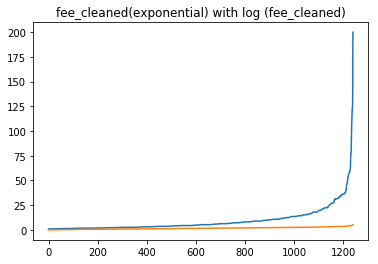

In [492]:
plt.plot(np.arange(0,1240),sort_y)
plt.plot(np.arange(0,1240),sort_log_y)
plt.title("fee_cleaned(exponential) with log (fee_cleaned)");

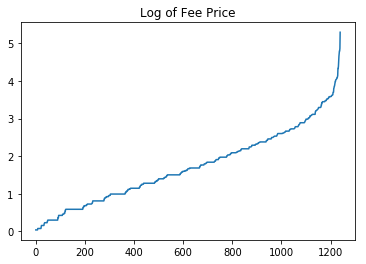

In [493]:
plt.plot(np.arange(0,1240),sort_log_y)
plt.title("Log of Fee Price");

In [494]:
#look at fee normalized
df_just_performance['fee_normal'] = (df_just_performance['fee_cleaned'] - df_just_performance['fee_cleaned'].mean())/df_just_performance['fee_cleaned'].std()



In [495]:
df_just_performance.head()

,Season_Transfer,age,fee_cleaned,year,height,Apps,Starts,Subs,Min,Mn/Ap,Gls,Ast,PK,PKatt,Fls,CrdY,CrdR,SoT,fee_normal
0,Davy_Pröpper 2015-16,23.0,4.05,2015.0,1.85,30.0,30.0,0.0,2584.0,86.0,5.0,4.0,0.0,0.0,74.0,5.0,1.0,23.0,-0.399072
1,Ryad_Boudebouz 2015-16,25.0,1.53,2015.0,1.77,34.0,32.0,2.0,2822.0,83.0,5.0,3.0,4.0,4.0,42.0,3.0,0.0,12.0,-0.581904
2,Kévin_Théophile-Catherine 2015-16,25.0,1.80,2015.0,1.83,31.0,30.0,1.0,2705.0,87.0,0.0,0.0,0.0,0.0,43.0,2.0,0.0,1.0,-0.562314
3,Raúl_Jiménez 2015-16,24.0,19.80,2015.0,1.90,21.0,4.0,17.0,598.0,29.0,1.0,2.0,0.0,0.0,14.0,0.0,0.0,11.0,0.743624
4,Karim_Rekik 2015-16,20.0,4.50,2015.0,1.86,26.0,26.0,0.0,2302.0,89.0,2.0,2.0,0.0,0.0,27.0,4.0,0.0,2.0,-0.366424


In [388]:
df_just_performance = df_just_performance.reset_index()

In [389]:
feather.write_dataframe(df_just_performance,"df_Performance.feather")

## I am going to filter out defenders because my performance statistics would really only be present for non-defenders

In [422]:
df_fb = feather.read_dataframe("df_FBRefStatistics.feather")
df_just_performance = feather.read_dataframe("df_Performance.feather")

In [425]:
df_fb.head(3)

,Nation,Pos,Squad,Age,Born,Apps,Starts,Subs,Min,Mn/Ap,Gls,Ast,PK,PKatt,Fls,CrdY,CrdR,SoT,Gls/90,G+A/90,G-PK/90,G+A-PK/90,SoT/90,Fls/90,Crd/90,Player_name,Player_under,Season_Transfer
0,NED,DF,AZ Alkmaar,23,1991,34,34,0,3060,90,1,3,0,0,41,4,0,7,0.03,0.12,0.03,0.12,0.21,1.21,0.12,Jeffrey Gouweleeuw,Jeffrey_Gouweleeuw,Jeffrey_Gouweleeuw 2015-16
1,NED,GK,NAC Breda,33,1980,34,34,0,3060,90,0,0,0,0,0,3,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.09,Jelle ten Rouwelaar,Jelle_ten_Rouwelaar,Jelle_ten_Rouwelaar 2015-16
2,SWE,GK,Heerenveen,25,1989,34,34,0,3060,90,0,0,0,0,0,2,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.06,Kristoffer Nordfeldt,Kristoffer_Nordfeldt,Kristoffer_Nordfeldt 2015-16


In [428]:
df_fb.shape

(19834, 28)

In [427]:
df_just_performance.head(3)

,Season_Transfer,age,fee_cleaned,year,height,Apps,Starts,Subs,Min,Mn/Ap,Gls,Ast,PK,PKatt,Fls,CrdY,CrdR,SoT,fee_normal
0,Davy_Pröpper 2015-16,23.0,4.05,2015.0,1.85,30.0,30.0,0.0,2584.0,86.0,5.0,4.0,0.0,0.0,74.0,5.0,1.0,23.0,-0.399072
1,Ryad_Boudebouz 2015-16,25.0,1.53,2015.0,1.77,34.0,32.0,2.0,2822.0,83.0,5.0,3.0,4.0,4.0,42.0,3.0,0.0,12.0,-0.581904
2,Kévin_Théophile-Catherine 2015-16,25.0,1.80,2015.0,1.83,31.0,30.0,1.0,2705.0,87.0,0.0,0.0,0.0,0.0,43.0,2.0,0.0,1.0,-0.562314


In [429]:
df_just_performance.shape

(1192, 19)

In [442]:
df_nodefenders = df_fb[["Pos", "Season_Transfer"]].merge(df_just_performance,how="inner", left_on="Season_Transfer",right_on="Season_Transfer")




In [443]:
df_nodefenders.shape

(1428, 20)

In [444]:
df_nodefenders.head(3)

,Pos,Season_Transfer,age,fee_cleaned,year,height,Apps,Starts,Subs,Min,Mn/Ap,Gls,Ast,PK,PKatt,Fls,CrdY,CrdR,SoT,fee_normal
0,DF,Jeffrey_Gouweleeuw 2015-16,24.0,2.7,2015.0,1.87,27.0,27.0,0.0,2385.0,88.0,0.0,0.0,0.0,0.0,31.0,4.0,0.0,2.0,-0.497018
1,DF,Jeffrey_Gouweleeuw 2015-16,24.0,2.7,2015.0,1.87,34.0,34.0,0.0,3060.0,90.0,1.0,3.0,0.0,0.0,41.0,4.0,0.0,7.0,-0.497018
2,DF,Jeffrey_Gouweleeuw 2015-16,24.0,2.7,2015.0,1.87,27.0,27.0,0.0,2385.0,88.0,0.0,0.0,0.0,0.0,31.0,4.0,0.0,2.0,-0.497018


In [445]:
df_nodefenders = df_nodefenders.drop_duplicates()

In [460]:
df_nodefenders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1245 entries, 0 to 1427
Data columns (total 20 columns):
Pos                1244 non-null object
Season_Transfer    1245 non-null object
age                1245 non-null float64
fee_cleaned        1245 non-null float64
year               1245 non-null float64
height             1245 non-null float64
Apps               1245 non-null float64
Starts             1245 non-null float64
Subs               1245 non-null float64
Min                1245 non-null float64
Mn/Ap              1245 non-null float64
Gls                1245 non-null float64
Ast                1245 non-null float64
PK                 1245 non-null float64
PKatt              1245 non-null float64
Fls                1245 non-null float64
CrdY               1245 non-null float64
CrdR               1245 non-null float64
SoT                1245 non-null float64
fee_normal         1245 non-null float64
dtypes: float64(18), object(2)
memory usage: 244.3+ KB


In [461]:
#looked up this null guy he is a defender anyway so will drop
df_nodefenders[df_nodefenders['Pos'].isnull()].index
df_nodefenders = df_nodefenders.drop(1121).reset_index()
df_nodefenders[df_nodefenders['Pos'].isnull()].index
df_nodefenders = df_nodefenders.drop(df_nodefenders.loc[df_nodefenders['Pos'].str.contains("DF|GK|DFFWMF|MFDFFW")].index)

Int64Index([1121], dtype='int64')

In [462]:
df_nodefenders = df_nodefenders.drop(1121).reset_index()

In [688]:
df_nodefenders[df_nodefenders.isnull()].index

Index(['Tjaronn_Chery 2015-16', 'Georginio_Wijnaldum 2015-16',
       'Nemanja_Gudelj 2015-16', 'Jesper_Drost 2015-16',
       'Jordy_Clasie 2015-16', 'Marten_de_Roon 2015-16', 'Mark_Uth 2015-16',
       'Mark_Uth 2015-16', 'Adnane_Tighadouini 2015-16',
       'Davy_Pröpper 2015-16',
       ...
       'Khouma_Babacar 2018-19', 'Khouma_Babacar 2018-19',
       'Manuel_Locatelli 2018-19', 'Stefano_Sturaro 2018-19',
       'Yann_Karamoh 2018-19', 'Grégoire_Defrel 2018-19',
       'Grégoire_Defrel 2018-19', 'Felipe_Avenatti 2018-19',
       'Marco_Tumminello 2018-19', 'Marco_Tumminello 2018-19'],
      dtype='object', name='Season_Transfer', length=846)

In [509]:
df_no_defenders = df_nodefenders.drop(["Mn/Ap", "CrdY", "CrdR", "PK", "PKatt", "Fls", "Subs", "Starts"],axis=1)

In [466]:
df_nodefenders['Pos'].value_counts()

MF        332
DF        277
FW        249
FWMF      141
MFFW      124
DFMF       64
MFDF       43
MFDFFW      7
FWMFDF      4
DFFWMF      2
GK          1
Name: Pos, dtype: int64

In [469]:
df_nodefenders = df_nodefenders.drop(df_nodefenders.loc[df_nodefenders['Pos'].str.contains("DF|GK|DFFWMF|MFDFFW")].index)

In [501]:
df_nodefenders = df_nodefenders.drop(["Pos","index"],axis=1).set_index("Season_Transfer")

## Modeling Below was just my initial Messing around look in notebook titled:
## "EDA and Modeling" to see official/more organized

In [502]:
fit_model_split(df_nodefenders, "fee_cleaned")

                                 OLS Regression Results                                
Dep. Variable:            fee_cleaned   R-squared (uncentered):                   0.433
Model:                            OLS   Adj. R-squared (uncentered):              0.422
Method:                 Least Squares   F-statistic:                              42.26
Date:                Wed, 17 Jul 2019   Prob (F-statistic):                    1.33e-91
Time:                        08:52:39   Log-Likelihood:                         -3405.9
No. Observations:                 846   AIC:                                      6842.
Df Residuals:                     831   BIC:                                      6913.
Df Model:                          15                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [503]:
fit_log_model_split(df_nodefenders,"fee_cleaned")

                                 OLS Regression Results                                
Dep. Variable:            fee_cleaned   R-squared (uncentered):                   0.803
Model:                            OLS   Adj. R-squared (uncentered):              0.800
Method:                 Least Squares   F-statistic:                              226.2
Date:                Wed, 17 Jul 2019   Prob (F-statistic):                   6.05e-281
Time:                        08:53:26   Log-Likelihood:                         -1104.4
No. Observations:                 846   AIC:                                      2239.
Df Residuals:                     831   BIC:                                      2310.
Df Model:                          15                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [511]:
from patsy import dmatrices,dmatrix

In [510]:
fit_model_split(df_no_defenders,"fee_cleaned")

                                 OLS Regression Results                                
Dep. Variable:            fee_cleaned   R-squared (uncentered):                   0.424
Model:                            OLS   Adj. R-squared (uncentered):              0.418
Method:                 Least Squares   F-statistic:                              77.01
Date:                Wed, 17 Jul 2019   Prob (F-statistic):                    4.92e-95
Time:                        09:02:50   Log-Likelihood:                         -3412.5
No. Observations:                 846   AIC:                                      6841.
Df Residuals:                     838   BIC:                                      6879.
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

## Patsy looking at interaction effects

In [530]:
y,X = dmatrices("fee_cleaned ~ age*Gls + year+ height + Apps + Min + Ast + SoT", df_no_defenders)


In [531]:
model_one = sm.OLS(y,X)
results = model_one.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            fee_cleaned   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     20.62
Date:                Wed, 17 Jul 2019   Prob (F-statistic):           1.41e-31
Time:                        11:02:16   Log-Likelihood:                -3406.6
No. Observations:                 846   AIC:                             6833.
Df Residuals:                     836   BIC:                             6881.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2463.5844    864.943     -2.848      0.0

In [541]:
y1,X1= dmatrices("np.log(fee_cleaned) ~ Gls + year + Apps + Ast + SoT", df_no_defenders)


In [542]:
model_two = sm.OLS(y1,X1)
results = model_two.fit()
print(results.summary())

                             OLS Regression Results                            
Dep. Variable:     np.log(fee_cleaned)   R-squared:                       0.149
Model:                             OLS   Adj. R-squared:                  0.144
Method:                  Least Squares   F-statistic:                     29.44
Date:                 Wed, 17 Jul 2019   Prob (F-statistic):           1.34e-27
Time:                         11:06:32   Log-Likelihood:                -1122.1
No. Observations:                  846   AIC:                             2256.
Df Residuals:                      840   BIC:                             2285.
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -81.5147     57.695     -1.41

In [519]:
from sklearn.ensemble import RandomForestRegressor

In [550]:
df_no_defenders

,age,fee_cleaned,year,height,Apps,Min,Gls,Ast,SoT,fee_normal
Season_Transfer,,,,,,,,,,
Tjaronn_Chery 2015-16,27.0,2.10,2015.0,1.71,34.0,3016.0,15.0,6.0,61.0,-0.540549
Georginio_Wijnaldum 2015-16,24.0,18.00,2015.0,1.75,33.0,2877.0,14.0,3.0,39.0,0.613030
Nemanja_Gudelj 2015-16,23.0,5.40,2015.0,1.88,32.0,2859.0,11.0,3.0,28.0,-0.301127
Jesper_Drost 2015-16,22.0,1.31,2015.0,1.75,33.0,2850.0,8.0,8.0,21.0,-0.597865
Jordy_Clasie 2015-16,24.0,13.50,2015.0,1.69,31.0,2778.0,2.0,5.0,9.0,0.286546
Marten_de_Roon 2015-16,24.0,1.17,2015.0,1.85,32.0,2765.0,1.0,0.0,13.0,-0.608022
Mark_Uth 2015-16,23.0,1.98,2015.0,1.85,31.0,2177.0,14.0,8.0,22.0,-0.549255
Mark_Uth 2015-16,23.0,1.98,2015.0,1.85,32.0,2665.0,15.0,8.0,41.0,-0.549255
Adnane_Tighadouini 2015-16,22.0,1.08,2015.0,1.79,33.0,2647.0,14.0,3.0,37.0,-0.614552


In [ ]:
y,X= dmatrices("fee_cleaned ~ Gls + year + Apps + Ast + SoT", df_no_defenders)

In [555]:
regr = RandomForestRegressor(max_depth=4,random_state=0,n_estimators=1000)

In [556]:
regr.fit(X,y)

/Users/sethweiland/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [557]:
regr.score(X,y)

0.5396204736895147

In [558]:
from sklearn.model_selection import train_test_split

In [573]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold

In [560]:
regr = RandomForestRegressor(max_depth=4,random_state=0,n_estimators=1000)

In [559]:
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.33)

In [562]:
y_train.shape

(566, 1)

In [564]:
regr.fit(X_train,y_train.ravel())

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [565]:
predictions = regr.predict(X_val)

In [566]:
np.mean(np.sum())

In [570]:
np.mean(error)

array(7.85187204)

In [578]:
cv_results = cross_validate(regr,X,y.ravel(),cv=4, scoring="r2", return_train_score=True)

In [579]:
cv_results

{'fit_time': array([1.15026212, 1.16257405, 1.22977996, 1.36993885]),
 'score_time': array([0.05481982, 0.06098795, 0.06332731, 0.06642938]),
 'test_score': array([-0.25365633,  0.19371285,  0.11306406,  0.12866199]),
 'train_score': array([0.61713401, 0.58998585, 0.48138681, 0.59256088])}

In [580]:
model = sm.OLS(y_train,X_train)

In [581]:
olsres = model.fit()

In [583]:
olsres.rsquared

0.20633591580594646

In [584]:
ypred = olsres.predict(X_val)

In [587]:
np.mean(abs(y_val-ypred))

array(8.71183561)

In [592]:
from sklearn.linear_model import Lasso,Ridge,ElasticNet

In [637]:
dictionary_model_alpha_score = {}

In [639]:
for alpha1 in alphas:
    model = Lasso(alpha=alpha1,fit_intercept=True)
    cv_results = cross_validate(model,X,y.ravel(),cv=4, 
                         scoring="r2", return_train_score=True)
    dictionary_model_alpha_score[f"Lasso: alpha={alpha1}"]=np.mean(cv_results['test_score'])
    #print(f"Lasso, alpha={alpha1}\nResults:\n{cv_results}\n")
          
    

In [640]:
for alpha1 in alphas:
    model = Ridge(alpha=alpha1,fit_intercept=True)
    cv_results = cross_validate(model,X,y.ravel(),cv=4, scoring="r2", 
                                return_train_score=True)
    dictionary_model_alpha_score[f"Ridge: alpha={alpha1}"]=np.mean(cv_results['test_score'])
    
    
    

In [641]:
for alpha1 in alphas:
    model = ElasticNet(alpha=alpha1,fit_intercept=True)
    cv_results = cross_validate(model,X,y.ravel(),cv=4, scoring="r2", 
                                return_train_score=True)
    dictionary_model_alpha_score[f"Elastic: alpha={alpha1}"]=np.mean(cv_results['test_score'])
    

In [642]:
for key,value in dictionary_model_alpha_score.items():
    print(key,value)

Lasso: alpha=0.1 0.038932415271393184
Lasso: alpha=0.2 0.035826763657977656
Lasso: alpha=0.3 0.03297139590423706
Lasso: alpha=0.4 0.03214463131314224
Lasso: alpha=0.5 0.035026119402000566
Lasso: alpha=0.6 0.03759279383602762
Lasso: alpha=0.7 0.039649570316276
Lasso: alpha=0.8 0.04116775143653237
Lasso: alpha=0.9 0.04243242184050652
Ridge: alpha=0.1 0.03845102880135459
Ridge: alpha=0.2 0.03857422749831291
Ridge: alpha=0.3 0.038686720786524464
Ridge: alpha=0.4 0.038789905831084465
Ridge: alpha=0.5 0.03888494872637785
Ridge: alpha=0.6 0.038972830057481644
Ridge: alpha=0.7 0.039054380146180234
Ridge: alpha=0.8 0.03913030659575642
Ridge: alpha=0.9 0.039201216020758906
Elastic: alpha=0.1 0.04198092056281558
Elastic: alpha=0.2 0.04222059158968308
Elastic: alpha=0.3 0.0420040951725425
Elastic: alpha=0.4 0.04173305838893235
Elastic: alpha=0.5 0.041627132090778896
Elastic: alpha=0.6 0.04142068530430487
Elastic: alpha=0.7 0.04111753010383415
Elastic: alpha=0.8 0.042261666925003494
Elastic: alpha=

## Log Test

In [649]:
dictionary_model_alpha_log_score = {}

In [650]:

for alpha1 in alphas:
    model = Lasso(alpha=alpha1,fit_intercept=True)
    cv_results = cross_validate(model,X,np.log(y.ravel()),cv=4, 
                         scoring="r2", return_train_score=True)
    dictionary_model_alpha_log_score[f"Lasso: alpha={alpha1}"]=np.mean(cv_results['test_score'])
    #print(f"Lasso, alpha={alpha1}\nResults:\n{cv_results}\n")
          

In [651]:
for alpha1 in alphas:
    model = Ridge(alpha=alpha1,fit_intercept=True)
    cv_results = cross_validate(model,X,np.log(y.ravel()),cv=4, scoring="r2", 
                                return_train_score=True)
    dictionary_model_alpha_log_score[f"Ridge: alpha={alpha1}"]=np.mean(cv_results['test_score'])
    
    
    

In [652]:
for alpha1 in alphas:
    model = ElasticNet(alpha=alpha1,fit_intercept=True)
    cv_results = cross_validate(model,X,np.log(y.ravel()),cv=4, scoring="r2", 
                                return_train_score=True)
    dictionary_model_alpha_log_score[f"Elastic: alpha={alpha1}"]=np.mean(cv_results['test_score'])
    

In [653]:
for key,value in dictionary_model_alpha_log_score.items():
    print(key,value)

Lasso: alpha=0.1 0.13149031673569728
Lasso: alpha=0.2 0.12582565249237068
Lasso: alpha=0.3 0.11301124379914651
Lasso: alpha=0.4 0.10413189727809105
Lasso: alpha=0.5 0.0959635743280558
Lasso: alpha=0.6 0.09523856082127147
Lasso: alpha=0.7 0.09505639779564928
Lasso: alpha=0.8 0.09496300821225662
Lasso: alpha=0.9 0.09494111123605897
Ridge: alpha=0.1 0.11097156139807743
Ridge: alpha=0.2 0.11111010357048598
Ridge: alpha=0.3 0.1112367630794546
Ridge: alpha=0.4 0.11135305859531128
Ridge: alpha=0.5 0.11146026212364993
Ridge: alpha=0.6 0.11155944687810859
Ridge: alpha=0.7 0.1116515244657616
Ridge: alpha=0.8 0.11173727405948461
Ridge: alpha=0.9 0.11181736549554597
Elastic: alpha=0.1 0.12946878285718644
Elastic: alpha=0.2 0.1313895494163738
Elastic: alpha=0.3 0.12981841111136552
Elastic: alpha=0.4 0.1253937828252519
Elastic: alpha=0.5 0.11928617378992185
Elastic: alpha=0.6 0.11266619518468848
Elastic: alpha=0.7 0.10820502246498342
Elastic: alpha=0.8 0.10391318999737453
Elastic: alpha=0.9 0.100093